## Trajectory analysis of GPS data - Kelowna (by SovereignAI) - Interpolation of GPS Points and Speed analysis

<H3> Part J3.0: Reading the data </H3>

In [1]:
!pip install osmnx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.6/99.6 kB 1.1 MB/s eta 0:00:00


In [2]:
!pip install movingpandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.2/78.2 kB 2.0 MB/s eta 0:00:00


In [3]:
!pip install contextily

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 23.9 MB/s eta 0:00:00


In [4]:
# Install required libraries
############################

import requests
import json
import time
import datetime
from urllib.request import urlopen
import requests
import warnings
from copy import copy

import numpy as np
import pandas as pd
import seaborn as sns
import osmnx as ox
import networkx as nx
import geopandas as gpd

from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from pyproj import CRS
import os
import movingpandas as mpd
from shapely.geometry import Point

# Suppress deprecation warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

/usr/local/lib/python3.11/dist-packages/movingpandas/__init__.py:41: UserWarning: Missing optional dependencies. To use the trajectory smoother classes please install Stone Soup (see https://stonesoup.readthedocs.io/en/latest/#installation).
  warnings.warn(e.msg, UserWarning)


In [5]:
# Reading files from drive
##########################

from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [6]:
# Read the GPS CSV files
########################

import pandas as pd
import geopandas as gpd
from shapely import wkt

# Read csv
'''
kelowna_gps = pd.read_csv('C:/data/gps_sai/Kelowna_Redo.csv')
'''
kelowna_gps_01Aug = pd.read_csv('/content/drive/MyDrive/Colab/2025-02-04/kelowna_gps_2023-08-01.csv')

# Display
kelowna_gps_01Aug

,DateTime,registrationID,latitude,longitude,recordCount
0,2023-08-01 00:16:50,741e7426-d14c-3da4-a8ac-2e20e5ea7cfb,49.837970,-119.489068,1
1,2023-08-01 00:22:51,741e7426-d14c-3da4-a8ac-2e20e5ea7cfb,49.837950,-119.489083,1
2,2023-08-01 00:22:56,741e7426-d14c-3da4-a8ac-2e20e5ea7cfb,49.837970,-119.489065,1
3,2023-08-01 00:28:50,741e7426-d14c-3da4-a8ac-2e20e5ea7cfb,49.837937,-119.489076,1
4,2023-08-01 00:28:53,741e7426-d14c-3da4-a8ac-2e20e5ea7cfb,49.837948,-119.489074,1
...,...,...,...,...,...
3107642,2023-08-01 14:59:45,9f8ac6f3-8425-36da-bba7-86dc38cc8590,49.932582,-119.348280,4
3107643,2023-08-01 14:59:37,9f8ac6f3-8425-36da-bba7-86dc38cc8590,49.932542,-119.348240,1
3107644,2023-08-01 14:59:46,9f8ac6f3-8425-36da-bba7-86dc38cc8590,49.932546,-119.348220,1
3107645,2023-08-01 14:59:33,9f8ac6f3-8425-36da-bba7-86dc38cc8590,49.932528,-119.348202,1


In [7]:
# Convert to geodataframe
#########################

import geopandas as gpd

# Create a geometry column from latitude and longitude and create gdf for Halifax
geometry = [Point(xy) for xy in zip(kelowna_gps_01Aug['longitude'], kelowna_gps_01Aug['latitude'])]
kelowna_gps_01Aug = gpd.GeoDataFrame(kelowna_gps_01Aug, geometry=geometry)

# Set the coordinate reference system (CRS) if needed
kelowna_gps_01Aug.set_crs(epsg=4326, inplace=True)  # WGS 84
display(kelowna_gps_01Aug)

,DateTime,registrationID,latitude,longitude,recordCount,geometry
0,2023-08-01 00:16:50,741e7426-d14c-3da4-a8ac-2e20e5ea7cfb,49.837970,-119.489068,1,POINT (-119.48907 49.83797)
1,2023-08-01 00:22:51,741e7426-d14c-3da4-a8ac-2e20e5ea7cfb,49.837950,-119.489083,1,POINT (-119.48908 49.83795)
2,2023-08-01 00:22:56,741e7426-d14c-3da4-a8ac-2e20e5ea7cfb,49.837970,-119.489065,1,POINT (-119.48906 49.83797)
3,2023-08-01 00:28:50,741e7426-d14c-3da4-a8ac-2e20e5ea7cfb,49.837937,-119.489076,1,POINT (-119.48908 49.83794)
4,2023-08-01 00:28:53,741e7426-d14c-3da4-a8ac-2e20e5ea7cfb,49.837948,-119.489074,1,POINT (-119.48907 49.83795)
...,...,...,...,...,...,...
3107642,2023-08-01 14:59:45,9f8ac6f3-8425-36da-bba7-86dc38cc8590,49.932582,-119.348280,4,POINT (-119.34828 49.93258)
3107643,2023-08-01 14:59:37,9f8ac6f3-8425-36da-bba7-86dc38cc8590,49.932542,-119.348240,1,POINT (-119.34824 49.93254)
3107644,2023-08-01 14:59:46,9f8ac6f3-8425-36da-bba7-86dc38cc8590,49.932546,-119.348220,1,POINT (-119.34822 49.93255)
3107645,2023-08-01 14:59:33,9f8ac6f3-8425-36da-bba7-86dc38cc8590,49.932528,-119.348202,1,POINT (-119.3482 49.93253)


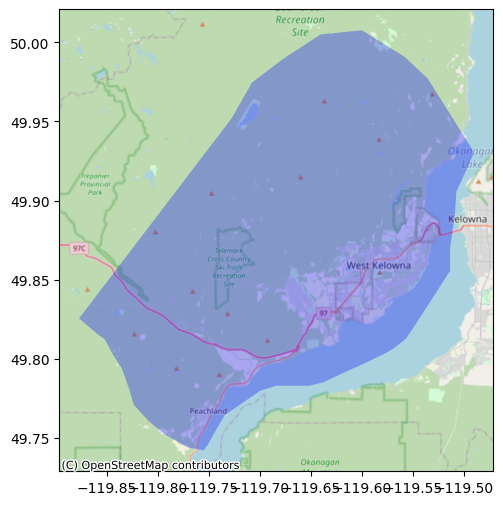

In [8]:
# Import and visualize the West Kelowna shapefile
#################################################

import contextily as ctx

path = '/content/drive/MyDrive/Colab/2025-02-04/West_Kelowna_1.shp'

w_kelowna_shp = gpd.read_file(path)

# Set the Coordinate Reference System (CRS) if not already set (WGS84 - EPSG:4326 for lat/long)
w_kelowna_shp.to_crs(epsg=4326, inplace=True)

# Plot the geometries on a basemap
fig, ax = plt.subplots(figsize=(6, 6))

# Plot the roads (your data)
w_kelowna_shp.plot(ax=ax, color='blue', linewidth=1, alpha=0.3)

# Use OpenStreetMap for the basemap
ctx.add_basemap(ax, crs=w_kelowna_shp.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik)

# Show the plot
plt.show()

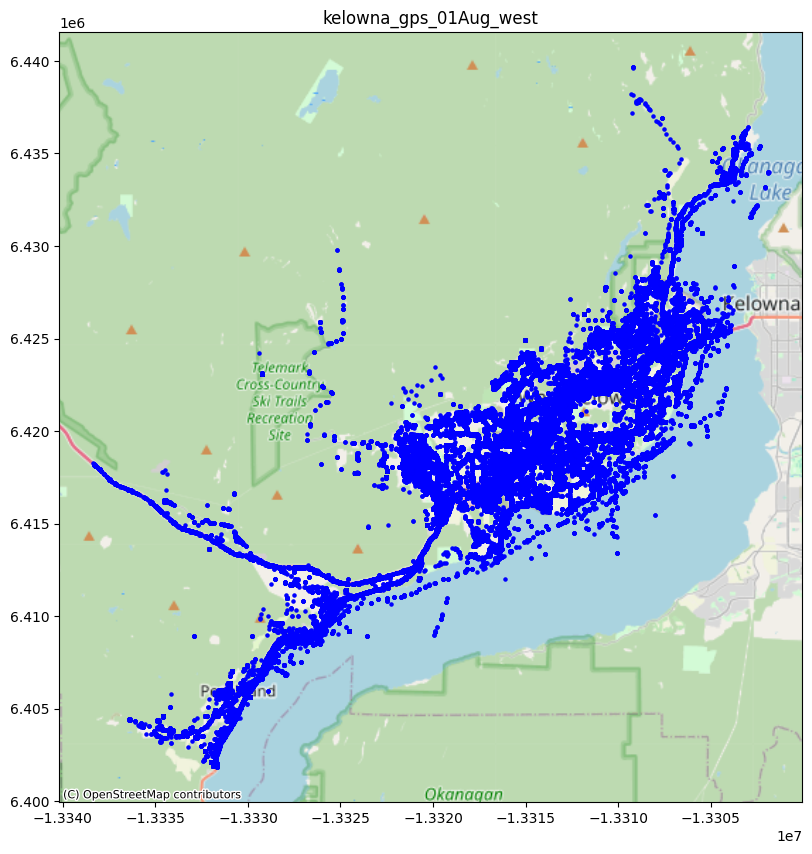

In [9]:
# Find out the GPS entries falling in West Kelowna
##################################################

# Ensure the CRS of both GeoDataFrames matches
kelowna_gps_01Aug = kelowna_gps_01Aug.to_crs(w_kelowna_shp.crs)

# Perform spatial join to get points near the NS101 highway buffer
kelowna_gps_01Aug_west = gpd.sjoin(
    kelowna_gps_01Aug,
    w_kelowna_shp,
    how="inner",
    predicate="intersects"
)

# No need to redefine geometry column if it's already a GeoDataFrame
kelowna_gps_01Aug_west = kelowna_gps_01Aug_west.to_crs(epsg=3857)

# Plot the filtered points
fig, ax = plt.subplots(figsize=(10, 10))
kelowna_gps_01Aug_west.plot(
    ax=ax, color='blue', markersize=5, label='kelowna_gps_01Aug_west'
)

# Add a basemap
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

# Customize the plot
ax.set_title("kelowna_gps_01Aug_west")
plt.show()


In [10]:
# Display the list of unique device_ids
#######################################

'''from cybstr.genera import prin'''


import os
import json
import time
import requests
import datetime
import warnings
import osmnx as ox
import numpy as np
import pandas as pd
import networkx as nx
import seaborn as sns
import geopandas as gpd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

from copy import copy
from pyproj import CRS
import contextily as ctx
import movingpandas as mpd
import matplotlib.pyplot as plt
from urllib.request import urlopen
from datetime import datetime, timedelta
from shapely.geometry import Point, LineString

#================================================================================================================================

def print_unique_gps_ids_v1(df, col_name, limt):
    """
    Convert a dataframe to geodataframe; and creates a geometry column.

    Parameters
    ----------
    df: pandas.DataFrame
        Dataframe containing GPS IDs.
    col_name: int
        The dataframe column containing the GPS IDs e.g. 'registrationID'.
    limt: int
        The frequency limit; e.g. if 10, will only show GPS IDs occuring more than 10 times.

    Returns
    -------
    gps_list: list
        List of GPS IDs.
    """
    unique_device_ids = df[col_name].unique()
    unique_device_ids_list = unique_device_ids.tolist()

    # Group by registrationID and filter for those with more than 20 entries
    grouped_device_ids = df.groupby(col_name).size()
    filtered_device_ids = grouped_device_ids[grouped_device_ids > limt].index.tolist()

    # Display
    return filtered_device_ids

#================================================================================================================================

# Column name and count limit
col_name = 'registrationID'
limt = 20

# Group by registrationID and filter for those with more than 20 entries
filtered_device_ids = print_unique_gps_ids_v1(kelowna_gps_01Aug_west, col_name, limt)

# Display the list of unique device_ids
print(filtered_device_ids[:50])

['0014e99a-2395-3b02-8045-1f216d74d289', '0022c192-3117-3b6d-bc6a-47324af16ae4', '0033e182-0d51-31d7-b919-ca16da4c07f6', '003b4c3a-8bc5-39e2-a32a-dee461460462', '003dbc24-010d-304d-93f4-26be722695e4', '00455d63-2a93-38bf-a8d3-1fe1e73d1e63', '004620ae-98e2-3513-bffb-c6835f4131fd', '00503d3a-567a-3260-94e8-4a246ba06616', '00556fee-7e68-3333-a5a6-e18442aabc0e', '00683bad-2667-35d8-9f64-9fefc1b2e5a4', '006ba957-0148-3bc7-a6d2-70fe0fc3104d', '0076db53-1ad1-3406-8630-99343c5d274a', '007f0538-04ae-3c5c-b8a0-1c80e9cc6e67', '007f408f-80fa-34b5-bdb1-4e7e2840e839', '009c557d-0739-3972-bd8d-80e9b069bcd6', '00b14771-6640-3fe7-af37-ec49439573ba', '00b23864-c778-398e-a720-899b18fd37f0', '00b40e86-6e27-3674-8378-1e750dd70197', '00c24562-1383-3474-8d98-ea44ea7084e1', '00ca0fe5-4990-3777-956e-de66e9ebc75e', '00cacf8d-4d63-3d31-b123-ae8122144e3c', '00d24373-091f-3df9-bff3-bc72741d9c1b', '00d6bfb2-4935-3bdc-abf5-ded6bc48e7a1', '00ea1ff3-be1f-3d7f-95e1-1616253da235', '00ea7bd5-d13d-3933-98c0-374c3ca63381',

In [11]:
# Data cleaning
###############

'''from cybstr.genera import preproc'''

def drop_less_freq_ids(df, col_name, freq):
    """
    Drop columns with GPS IDs occuring less than 'freq' times

    Parameters
    ----------
    df: pandas.DataFrame
        Dataframe containing GPS IDs.
    col_name: string
        The dataframe column containing the GPS IDs e.g. 'registrationID'.
    freq: int
        The frequency limit; e.g. if 3, will drop IDs which occur less than 3 times.

    Returns
    -------
    df: pandas.DataFrame
        Dataframe after IDs have been dropped.
    num_less_freq_ids: int
        The number of IDs occurring less than 'freq' times.
    """
    # Drop duplicates
    df = df.drop_duplicates()

    # Count occurrences of each registrationID
    registration_counts = df[col_name].value_counts()

    # Identify IDs that occur less than 4 times
    less_freq_ids = registration_counts[registration_counts < freq].index

    # Calculate the number of such IDs
    num_less_freq_ids = len(less_freq_ids)

    # Drop rows with registrationIDs that occur only once
    df = df[~df[col_name].isin(less_freq_ids)]

    # Return
    return df, num_less_freq_ids

# Column name and count limit
col_name = 'registrationID'
freq = 2

# Drop less frequent GPS columns
kelowna_gps_01Aug_west, num_thrice_occurrence_ids = drop_less_freq_ids(kelowna_gps_01Aug_west, col_name, freq)

# Calculate the number of such IDs
print(f"Number of registrationIDs occurring less than {freq} times in kelowna_gps_01Aug_west: {num_thrice_occurrence_ids}")


Number of registrationIDs occurring less than 2 times in kelowna_gps_01Aug_west: 1945


In [12]:
# Data cleaning - dropping rows with duplicate registrationID + Time combo
##########################################################################

'''from cybstr.genera import preproc'''

def drop_duplicate_gps(df, gps_col_name, date_col_name):
    """
    Drop columns with duplicate GPS ID + Time value

    Parameters
    ----------
    df: pandas.DataFrame
        Dataframe containing GPS IDs.
    gps_col_name: string
        The dataframe column containing the GPS IDs e.g. 'registrationID'.
    date_col_name: string
        The dataframe column containing the GPS IDs e.g. 'DateTime'.

    Returns
    -------
    df: pandas.DataFrame
        Dataframe after IDs have been dropped.
    rows_dropped: int
        The number of rows dropped.
    """
    # Drop duplicates
    df = df.drop_duplicates()
    df[date_col_name] = pd.to_datetime(df[date_col_name])

    # Shape before dropping duplicates
    rows_before = df.shape[0]

    # Drop rows with duplicate registrationID and DateTime
    df = df.drop_duplicates(subset=[gps_col_name, date_col_name])

    # Shape after dropping duplicates
    rows_after = df.shape[0]

    # Calculate and print the number of rows dropped
    rows_dropped = rows_before - rows_after

    # Display
    return df, rows_dropped

# Column name and count limit
gps_col_name = 'registrationID'
date_col_name = 'DateTime'

# Drop duplicates
kelowna_gps_01Aug_west, rows_dropped = drop_duplicate_gps(kelowna_gps_01Aug_west, gps_col_name, date_col_name)
kelowna_gps_01Aug_west = kelowna_gps_01Aug_west.to_crs(epsg=4326)

print(f"Number of rows dropped: {rows_dropped}")
display(kelowna_gps_01Aug_west)

Number of rows dropped: 57773


,DateTime,registrationID,latitude,longitude,recordCount,geometry,index_right,Id
13499,2023-08-01 17:49:01,2e732bbe-7211-3f90-8557-693e230bfb51,49.856814,-119.531064,1,POINT (-119.53106 49.85681),0,0
13500,2023-08-01 17:49:05,2e732bbe-7211-3f90-8557-693e230bfb51,49.856803,-119.531073,1,POINT (-119.53107 49.8568),0,0
13501,2023-08-01 17:49:51,2e732bbe-7211-3f90-8557-693e230bfb51,49.856836,-119.531099,3,POINT (-119.5311 49.85684),0,0
13502,2023-08-01 17:49:56,2e732bbe-7211-3f90-8557-693e230bfb51,49.856844,-119.531088,1,POINT (-119.53109 49.85684),0,0
13503,2023-08-01 17:49:52,2e732bbe-7211-3f90-8557-693e230bfb51,49.856858,-119.531065,1,POINT (-119.53107 49.85686),0,0
...,...,...,...,...,...,...,...,...
3094802,2023-08-01 13:22:08,4d2a526b-e55b-3907-9a82-5f87d8c64331,49.839259,-119.610078,1,POINT (-119.61008 49.83926),0,0
3094803,2023-08-01 15:40:16,8b0229d0-eb77-3f1f-9b19-99833f2fd29a,49.839161,-119.610040,1,POINT (-119.61004 49.83916),0,0
3094805,2023-08-01 17:17:46,471d3c2b-341b-3890-83f0-500b6d87d105,49.839326,-119.609867,1,POINT (-119.60987 49.83933),0,0
3094806,2023-08-01 17:17:48,471d3c2b-341b-3890-83f0-500b6d87d105,49.839327,-119.609849,3,POINT (-119.60985 49.83933),0,0


In [13]:
# Data cleaning - dropping GPS IDs with no movement (upto 3 decimal places in latitude/longitude)
#################################################################################################

'''from cybstr.genera import preproc'''

def remove_static_gps_entries(df):
    """
    Removes GPS entries where the device shows no movement (same latitude and longitude rounded to 3 decimal places).

    Args:
        df (pd.DataFrame): DataFrame containing GPS data with 'registrationID', 'latitude', and 'longitude'.

    Returns:
        pd.DataFrame: Filtered DataFrame with moving GPS entries only.
    """
    # Round latitude and longitude to 3 decimal places
    df["_lat_rounded"] = df["latitude"].round(3)
    df["_lon_rounded"] = df["longitude"].round(3)

    # Identify registrationIDs with no movement
    static_ids = df.groupby("registrationID").filter(lambda x: x[["_lat_rounded", "_lon_rounded"]].nunique().sum() == 2)["registrationID"].unique()

    # Count rows to be dropped
    rows_dropped = df[df["registrationID"].isin(static_ids)].shape[0]

    # Drop static registrationIDs
    df_filtered = df[~df["registrationID"].isin(static_ids)].copy()

    # Drop temporary columns
    df_filtered.drop(columns=["_lat_rounded", "_lon_rounded"], inplace=True)

    # Print the number of IDs and rows dropped
    print(f"Dropped {len(static_ids)} registrationIDs with no movement, removing {rows_dropped} rows.")

    return df_filtered

kelowna_gps_01Aug_west = remove_static_gps_entries(kelowna_gps_01Aug_west)

Dropped 8918 registrationIDs with no movement, removing 259732 rows.


In [14]:
# Basic analysis - Data duration
################################

# Calculate the start and end times
start_time_k = kelowna_gps_01Aug_west['DateTime'].min()
end_time_k = kelowna_gps_01Aug_west['DateTime'].max()

print(f"kelowna_gps_01Aug_west data was collected from {start_time_k} to {end_time_k}.")

kelowna_gps_01Aug_west data was collected from 2023-08-01 00:00:00 to 2023-08-01 23:59:59.


<H3>Part J2.2: Trajectory for all IDs in a day</H3>

In [15]:
# Read map matched trajectory CSV file
######################################

import pandas as pd
import geopandas as gpd
from shapely import wkt

# Read csv
'''
kelowna_gps = pd.read_csv('C:/data/gps_sai/Kelowna_Redo.csv')
'''
matched_trips_kelowna_gps_01Aug_west_1 = pd.read_csv('/content/drive/MyDrive/Colab/2025-02-04/matched_trips_kelowna_gps_01Aug_west_1.csv')

# Display
matched_trips_kelowna_gps_01Aug_west_1

,Unnamed: 0,day,gps_id,trip_id,geometry,time_pos_dict
0,0,2023-08-01,003b4c3a-8bc5-39e2-a32a-dee461460462,8,LINESTRING (-119.66147369041835 49.80884786459...,{Timestamp('2023-08-01 18:37:23'): <POINT (-11...
1,1,2023-08-01,004620ae-98e2-3513-bffb-c6835f4131fd,12,LINESTRING (-119.66873419094402 49.83240472155...,{Timestamp('2023-08-01 11:32:32'): <POINT (-11...
2,2,2023-08-01,004620ae-98e2-3513-bffb-c6835f4131fd,13,LINESTRING (-119.6684533174653 49.832652048827...,{Timestamp('2023-08-01 15:31:37'): <POINT (-11...
3,3,2023-08-01,004620ae-98e2-3513-bffb-c6835f4131fd,14,"LINESTRING (-119.6686978 49.8453946, -119.6681...",{Timestamp('2023-08-01 18:58:01'): <POINT (-11...
4,4,2023-08-01,005a1d04-c1c0-3ec6-a0e3-ced44621ffb4,18,"LINESTRING (-119.6292979 49.8260618, -119.6287...",{Timestamp('2023-08-01 20:09:40'): <POINT (-11...
...,...,...,...,...,...,...
4716,4716,2023-08-01,ffe7819e-57ff-3af1-b3fb-29fac2a7a23f,18504,LINESTRING (-119.58328989879269 49.86271270797...,{Timestamp('2023-08-01 14:09:45'): <POINT (-11...
4717,4717,2023-08-01,ffe94a10-c86d-374a-a72b-4bb11910e4a6,18511,LINESTRING (-119.58316836783015 49.86263678123...,{Timestamp('2023-08-01 16:04:42'): <POINT (-11...
4718,4718,2023-08-01,ffecb3f6-1123-34ca-810f-76486ae5c5c8,18516,"LINESTRING (-119.5636836 49.8628304, -119.5645...",{Timestamp('2023-08-01 21:38:27'): <POINT (-11...
4719,4719,2023-08-01,fffaa8d2-af8c-3ee6-b17d-0dd5ab63b5c1,18521,LINESTRING (-119.58316836783015 49.86263678123...,{Timestamp('2023-08-01 16:13:08'): <POINT (-11...


In [16]:
from shapely.geometry import Point, LineString
import pandas as pd
from shapely.wkt import loads
import geopandas as gpd

def compute_along_trajectory_distance_v2(gps_df, trajectory_df, crs="EPSG:4326", metric_crs="EPSG:3857"):
    """
    Compute distance between successive GPS points along a given trajectory.

    gps_df: DataFrame containing GPS points with 'gps_id', 'trip_id', 'datetime', and 'geometry' columns.
    trajectory_df: DataFrame containing trajectory data with 'gps_id', 'trip_id', and 'geometry' columns.
    crs: Coordinate Reference System of input data (default: EPSG:4326 - WGS84).
    metric_crs: Projected CRS for accurate distance calculations (default: EPSG:3857 - Web Mercator).

    Returns:
    gps_df with new columns:
      - 'dist_along_trajectory' (meters)
      - 'speed_kmh' (km/h)
    """

    # Convert WKT strings to Shapely geometries if necessary
    gps_df["geometry"] = gps_df["geometry"].apply(lambda x: loads(x) if isinstance(x, str) else x)
    trajectory_df["geometry"] = trajectory_df["geometry"].apply(lambda x: loads(x) if isinstance(x, str) else x)

    # Convert to GeoDataFrame and set CRS
    gps_gdf = gpd.GeoDataFrame(gps_df, geometry="geometry", crs=crs)
    traj_gdf = gpd.GeoDataFrame(trajectory_df, geometry="geometry", crs=crs)

    # Extract unique gps_id and trip_id from gps_df
    unique_gps_ids = gps_gdf["gps_id"].unique()
    unique_trip_ids = gps_gdf["trip_id"].unique()

    # Check if multiple gps_ids or trip_ids are present
    if len(unique_gps_ids) > 1 or len(unique_trip_ids) > 1:
        print("Error: gps_df contains multiple gps_ids or trip_ids. Function expects only one.")
        return None

    gps_id = unique_gps_ids[0]
    trip_id = unique_trip_ids[0]

    # Extract the matching trajectory
    matching_traj = traj_gdf[(traj_gdf["gps_id"] == gps_id) & (traj_gdf["trip_id"] == trip_id)]

    # Ensure there is only one matching trajectory
    if len(matching_traj) == 0:
        print(f"Error: No trajectory found for gps_id={gps_id} and trip_id={trip_id}.")
        return None
    elif len(matching_traj) > 1:
        print(f"Error: Multiple trajectories found for gps_id={gps_id} and trip_id={trip_id}.")
        return None

    trajectory = matching_traj.iloc[0]["geometry"]  # Get the LineString

    # Sort GPS points by timestamp
    gps_gdf = gps_gdf.sort_values("datetime").reset_index(drop=True)

    # Convert both GPS points and trajectory to metric CRS (for distance calculations)
    gps_gdf = gps_gdf.to_crs(metric_crs)
    traj_gdf = traj_gdf.to_crs(metric_crs)
    trajectory = traj_gdf.iloc[0]["geometry"]  # Reprojected trajectory

    # Project each GPS point onto the trajectory
    gps_gdf["proj_dist"] = gps_gdf["geometry"].apply(lambda point: trajectory.project(point))

    # Compute distance along trajectory (meters)
    gps_gdf["dist_along_trajectory"] = gps_gdf["proj_dist"].diff().fillna(0)  # First point has no previous

    # Convert datetime column to datetime format
    gps_gdf["datetime"] = pd.to_datetime(gps_gdf["datetime"])

    # Compute time difference in hours
    gps_gdf["time_diff_hours"] = gps_gdf["datetime"].diff().dt.total_seconds().div(3600).fillna(0)

    # Compute speed in km/h
    gps_gdf["speed_kmh"] = gps_gdf["dist_along_trajectory"] / gps_gdf["time_diff_hours"]

    return gps_gdf


In [17]:
from shapely.geometry import Point, LineString
import pandas as pd
from shapely.wkt import loads
import geopandas as gpd

def compute_along_trajectory_distance_test0(gps_df, trajectory, crs="EPSG:4326", metric_crs="EPSG:3857"):

    # Convert WKT strings to Shapely geometries if necessary
    gps_df["geometry"] = gps_df["geometry"].apply(lambda x: loads(x) if isinstance(x, str) else x)
    #trajectory_df["geometry"] = trajectory_df["geometry"].apply(lambda x: loads(x) if isinstance(x, str) else x)

    # Convert to GeoDataFrame and set CRS
    gps_gdf = gpd.GeoDataFrame(gps_df, geometry="geometry", crs=crs)
    #traj_gdf = gpd.GeoDataFrame(trajectory_df, geometry="geometry", crs=crs)

    # Extract unique gps_id and trip_id from gps_df
    unique_gps_ids = gps_gdf["registrationID"].unique()
    unique_trip_ids = gps_gdf["trip_id"].unique()

    # Check if multiple gps_ids or trip_ids are present
    if len(unique_gps_ids) > 1 or len(unique_trip_ids) > 1:
        print("Error: gps_df contains multiple gps_ids or trip_ids. Function expects only one.")
        return None

    gps_id = unique_gps_ids[0]
    trip_id = unique_trip_ids[0]



    # Sort GPS points by timestamp
    gps_gdf = gps_gdf.sort_values("DateTime").reset_index(drop=True)

    # Convert both GPS points and trajectory to metric CRS (for distance calculations)
    gps_gdf = gps_gdf.to_crs(metric_crs)

    # Project each GPS point onto the trajectory
    gps_gdf["proj_dist"] = gps_gdf["geometry"].apply(lambda point: trajectory.project(point))

    # Compute distance along trajectory (meters)
    gps_gdf["dist_along_trajectory"] = gps_gdf["proj_dist"].diff().fillna(0)  # First point has no previous

    # Convert datetime column to datetime format
    gps_gdf["DateTime"] = pd.to_datetime(gps_gdf["DateTime"])

    # Compute time difference in hours
    gps_gdf["time_diff_hours"] = gps_gdf["DateTime"].diff().dt.total_seconds().div(3600).fillna(0)

    # Compute speed in km/h
    gps_gdf["speed_kmh"] = gps_gdf["dist_along_trajectory"] / gps_gdf["time_diff_hours"]

    return gps_gdf


In [18]:
# Assign trip_ids based on 1hr gap between consecutive GPS points
#################################################################

'''from cybstr.traject import trip_analysis'''

def calculate_trip_id(df, gps_col_name, date_col_name, timelimt):
    """
    Calculate trip ids based on a time limit i.e. if 1hr, every subsequent GPS entry after 1hr will be a new trip.

    Parameters
    ----------
    df : GeoDataFrame
        The GPS dataframe containing location and time.
    gps_col_name: string
        The dataframe column containing the GPS IDs e.g. 'registrationID'.
    date_col_name: string
        The dataframe column containing the GPS IDs e.g. 'DateTime'.
    timelimt: int (seconds)
        The cutoff time for a new trip i.e. if 3600, every subsequent entry after 3600 sec/1 hr is a new trip.

    Returns
    -------
    GeoDataFrame
        A GeoDataFrame containing two new columns:
        time_diff = The time difference between GPS points in seconds
        trip_id = A number denoting the ID of the trip
    """

    # Convert DateTime column to datetime type
    df[date_col_name] = pd.to_datetime(df[date_col_name])

    # Sort by registrationID and DateTime to ensure proper order
    df = df.sort_values(by=[gps_col_name, date_col_name])

    # Calculate time difference in seconds between consecutive rows
    df.loc[:,"time_diff"] = df[date_col_name].diff().dt.total_seconds()

    # Assign trip_id based on the desired time gap
    df.loc[:,"trip_id"] = (df["time_diff"] > timelimt).cumsum() + 1

    # Fill NaN for the first row's time_diff
    df.loc[:,"time_diff"] = df["time_diff"].fillna(0)

    # Return the df
    return df

# Constants: column names and time limit trip
gps_col_name = "registrationID"
date_col_name = "DateTime"
timelimt = 3600

# Return and print the df
kelowna_gps_01Aug_west = calculate_trip_id(kelowna_gps_01Aug_west, gps_col_name, date_col_name, timelimt)
kelowna_gps_01Aug_west = kelowna_gps_01Aug_west.to_crs(epsg=4326)
display(kelowna_gps_01Aug_west.head())


,DateTime,registrationID,latitude,longitude,recordCount,geometry,index_right,Id,time_diff,trip_id
934264,2023-08-01 00:00:33,0022c192-3117-3b6d-bc6a-47324af16ae4,49.846114,-119.667471,1,POINT (-119.66747 49.84611),0,0,0.0,1
934265,2023-08-01 00:00:35,0022c192-3117-3b6d-bc6a-47324af16ae4,49.846104,-119.667471,1,POINT (-119.66747 49.8461),0,0,2.0,1
934462,2023-08-01 00:00:38,0022c192-3117-3b6d-bc6a-47324af16ae4,49.846160,-119.667454,1,POINT (-119.66745 49.84616),0,0,3.0,1
934729,2023-08-01 00:00:42,0022c192-3117-3b6d-bc6a-47324af16ae4,49.846185,-119.667432,2,POINT (-119.66743 49.84618),0,0,4.0,1
934365,2023-08-01 00:05:02,0022c192-3117-3b6d-bc6a-47324af16ae4,49.846112,-119.667436,1,POINT (-119.66744 49.84611),0,0,260.0,1


In [19]:
''' # This is giving weird map
tempdf = kelowna_gps_01Aug_west[kelowna_gps_01Aug_west['registrationID']=='003b4c3a-8bc5-39e2-a32a-dee461460462']
tempdf
'''

tempdf = kelowna_gps_01Aug_west[kelowna_gps_01Aug_west['registrationID']=='6a750f3f-7308-30a7-bc84-000b21210e1e']
tempdf

,DateTime,registrationID,latitude,longitude,recordCount,geometry,index_right,Id,time_diff,trip_id
827682,2023-08-01 00:45:38,6a750f3f-7308-30a7-bc84-000b21210e1e,49.861640,-119.587501,2,POINT (-119.5875 49.86164),0,0,-8820.0,3735
373321,2023-08-01 00:46:31,6a750f3f-7308-30a7-bc84-000b21210e1e,49.854423,-119.596781,2,POINT (-119.59678 49.85442),0,0,53.0,3735
1596963,2023-08-01 01:01:33,6a750f3f-7308-30a7-bc84-000b21210e1e,49.829753,-119.629546,2,POINT (-119.62955 49.82975),0,0,902.0,3735
1596957,2023-08-01 01:02:37,6a750f3f-7308-30a7-bc84-000b21210e1e,49.829719,-119.629586,2,POINT (-119.62959 49.82972),0,0,64.0,3735
1596966,2023-08-01 04:22:52,6a750f3f-7308-30a7-bc84-000b21210e1e,49.829715,-119.629509,2,POINT (-119.62951 49.82972),0,0,12015.0,3736
1596958,2023-08-01 04:50:22,6a750f3f-7308-30a7-bc84-000b21210e1e,49.829710,-119.629602,2,POINT (-119.6296 49.82971),0,0,1650.0,3736
1596959,2023-08-01 05:04:55,6a750f3f-7308-30a7-bc84-000b21210e1e,49.829719,-119.629590,2,POINT (-119.62959 49.82972),0,0,873.0,3736
1597827,2023-08-01 05:20:42,6a750f3f-7308-30a7-bc84-000b21210e1e,49.829884,-119.629699,2,POINT (-119.6297 49.82988),0,0,947.0,3736
1584143,2023-08-01 05:23:38,6a750f3f-7308-30a7-bc84-000b21210e1e,49.833551,-119.631016,2,POINT (-119.63102 49.83355),0,0,176.0,3736
3089199,2023-08-01 05:33:31,6a750f3f-7308-30a7-bc84-000b21210e1e,49.837233,-119.616421,2,POINT (-119.61642 49.83723),0,0,593.0,3736


In [20]:
tempdf_2 = tempdf[tempdf['trip_id']==3736]
tempdf_2

,DateTime,registrationID,latitude,longitude,recordCount,geometry,index_right,Id,time_diff,trip_id
1596966,2023-08-01 04:22:52,6a750f3f-7308-30a7-bc84-000b21210e1e,49.829715,-119.629509,2,POINT (-119.62951 49.82972),0,0,12015.0,3736
1596958,2023-08-01 04:50:22,6a750f3f-7308-30a7-bc84-000b21210e1e,49.829710,-119.629602,2,POINT (-119.6296 49.82971),0,0,1650.0,3736
1596959,2023-08-01 05:04:55,6a750f3f-7308-30a7-bc84-000b21210e1e,49.829719,-119.629590,2,POINT (-119.62959 49.82972),0,0,873.0,3736
1597827,2023-08-01 05:20:42,6a750f3f-7308-30a7-bc84-000b21210e1e,49.829884,-119.629699,2,POINT (-119.6297 49.82988),0,0,947.0,3736
1584143,2023-08-01 05:23:38,6a750f3f-7308-30a7-bc84-000b21210e1e,49.833551,-119.631016,2,POINT (-119.63102 49.83355),0,0,176.0,3736
3089199,2023-08-01 05:33:31,6a750f3f-7308-30a7-bc84-000b21210e1e,49.837233,-119.616421,2,POINT (-119.61642 49.83723),0,0,593.0,3736
3090015,2023-08-01 05:33:40,6a750f3f-7308-30a7-bc84-000b21210e1e,49.837647,-119.615901,2,POINT (-119.6159 49.83765),0,0,9.0,3736
1637151,2023-08-01 05:34:08,6a750f3f-7308-30a7-bc84-000b21210e1e,49.839510,-119.613784,2,POINT (-119.61378 49.83951),0,0,28.0,3736
1637156,2023-08-01 05:34:20,6a750f3f-7308-30a7-bc84-000b21210e1e,49.839892,-119.614294,2,POINT (-119.61429 49.83989),0,0,12.0,3736
1637226,2023-08-01 05:39:54,6a750f3f-7308-30a7-bc84-000b21210e1e,49.840764,-119.614779,2,POINT (-119.61478 49.84076),0,0,334.0,3736


In [21]:
# Plot above in folium
######################

import folium

# Convert the 'DateTime' column to datetime format
tempdf['DateTime'] = pd.to_datetime(tempdf['DateTime'])

# Initialize the map centered around the mean coordinates of the data
m = folium.Map(location=[tempdf['latitude'].mean(), tempdf['longitude'].mean()], zoom_start=15)

# Add markers for each row in the dataframe
for _, row in tempdf.iterrows():
    folium.Marker(
        location=[row['latitude'], row['longitude']],
        popup=f"DateTime: {row['DateTime']}<br>RegistrationID: {row['registrationID']}<br>Time Diff: {row['time_diff']} seconds",
        icon=folium.Icon(color='blue', icon='info-sign')
    ).add_to(m)

# Display map if needed
m


/usr/local/lib/python3.11/dist-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [22]:
# Plot the trajectory linestring in Folium
##########################################

import folium
import shapely.wkt
from shapely.geometry import LineString

# Define the LINESTRING value as a string
line_wkt = "LINESTRING (-119.62959729736691 49.82957970827294, -119.63028339835715 49.82957843840236, -119.6309695 49.8295786, -119.6309966 49.8299991, -119.6310333 49.8304842, -119.63103916250434 49.83090941586005, -119.631047 49.8313346, -119.6310494 49.8315734, -119.6310516 49.8317871, -119.6310563 49.8322187, -119.63106135 49.83268005, -119.6310664 49.8331414, -119.631071225 49.833589075000006, -119.63107604999999 49.83403675, -119.631080875 49.834484425, -119.6310857 49.8349321, -119.6303332 49.8349416, -119.6295807 49.8349511, -119.62889845000001 49.834955699999995, -119.6282162 49.8349603, -119.62752175 49.83497345, -119.6268273 49.8349866, -119.6261269 49.8350004, -119.6254456 49.8350101, -119.62471451610628 49.83501174221418, -119.62398344847392 49.83501317136952, -119.62325713963254 49.8349478411541, -119.6225681 49.8347125, -119.62199071974507 49.83504598687138, -119.62133599691309 49.83510613250916, -119.6206693 49.8350963, -119.6198257 49.8350779, -119.619287 49.83506705, -119.6187483 49.8350562, -119.6185921 49.8354461, -119.6184947 49.8357004, -119.618436 49.8357922, -119.6180264 49.836138, -119.6173771 49.8366598, -119.6170801 49.8367271, -119.6169311 49.8367272, -119.6167741 49.8368786, -119.6167911 49.836926, -119.6166465 49.8371736, -119.6162417 49.8374728, -119.6158737341285 49.83774652038441, -119.6155038 49.8380176, -119.61504356995705 49.838354984835156, -119.61458364543573 49.83869278574129, -119.61412412070692 49.83903113023536, -119.6136661 49.8393715, -119.61426515 49.83973135, -119.6148642 49.8400912, -119.6154045 49.8403978, -119.6152013 49.8405604, -119.615036 49.8404641, -119.6152013 49.8405604, -119.6155193 49.8408573, -119.6152013 49.8405604, -119.6154045 49.8403978, -119.6148642 49.8400912, -119.61440726912419 49.84042724683816, -119.6139505175022 49.84076353771825, -119.61349372993111 49.84109977975134, -119.6139505175022 49.84076353771825, -119.61440726912419 49.84042724683816, -119.6148642 49.8400912, -119.61426515 49.83973135, -119.6136661 49.8393715, -119.61412412070692 49.83903113023536, -119.61458364543573 49.83869278574129, -119.61504356995705 49.838354984835156, -119.6155038 49.8380176, -119.6158737341285 49.83774652038441, -119.6162417 49.8374728, -119.6166465 49.8371736, -119.6169631 49.8370161, -119.6167911 49.836926, -119.6167741 49.8368786, -119.6169311 49.8367272, -119.6161666 49.8364043, -119.615834 49.8362207, -119.615677 49.8361335, -119.615574 49.8362115, -119.615307 49.8364129, -119.61482346223076 49.836773910942554, -119.6143399244615 49.83713492188511, -119.61385638669226 49.837495932827665, -119.613372848923 49.83785694377022, -119.61288931115376 49.83821795471278, -119.61240577338451 49.83857896565534, -119.6119161 49.8389316, -119.61136905000001 49.839328050000006, -119.610822 49.8397245, -119.6105 49.8399667, -119.6101579 49.8402138, -119.60970736606139 49.84055762921416, -119.60925683212277 49.84090145842831, -119.60880629818415 49.84124528764247, -119.60835499069125 49.84158808619182, -119.60789899723451 49.8419246412776, -119.60744300377777 49.84226119636338, -119.60698751612281 49.84259843512459, -119.60653228894583 49.84293602596525, -119.60607706176886 49.8432736168059, -119.60562183459187 49.84361120764655, -119.60516427856065 49.843945628333174, -119.60470602402732 49.84427909818345, -119.60424776949401 49.844612568033725, -119.60379079714167 49.84494777641737, -119.60333683814572 49.84528707066776, -119.60288287914976 49.84562636491815, -119.60242222124864 49.84595638403277, -119.60195741615121 49.8462806610436, -119.60150190944812 49.84661785938867, -119.6010467798556 49.84695558177816, -119.600606 49.8473116, -119.6001333 49.8477471, -119.5998889 49.8480117, -119.59957678505111 49.84837191868654, -119.59928838519546 49.84875129438697, -119.5990378296952 49.84915591234356, -119.59882498306116 49.84958237401104, -119.59863026126355 49.850017289620325, -119.59843432439901 49.85045172559505, -119.59823180516923 49.850883187302536, -119.59802928593946 49.851314649010014, -119.5978267667097 49.8517461107175, -119.59762424747993 49.85217757242498, -119.59742172825015 49.85260903413246, -119.5972179130145 49.8530398783942, -119.59701044075098 49.853468980367296, -119.59680296848745 49.8538980823404, -119.59657362288951 49.85431521834134, -119.59632417142444 49.85472135527641, -119.59607471995938 49.85512749221148, -119.59578336185794 49.85550463952345, -119.5954913 49.8558813, -119.594831 49.8560713, -119.5949952 49.8564001, -119.59456867659709 49.856803085848796, -119.59413948195561 49.85720305642176, -119.5936598931015 49.85754117553377, -119.59318030424741 49.85787929464578, -119.5927007153933 49.85821741375778, -119.59222112653921 49.85855553286979, -119.59174153768511 49.858893651981795, -119.59126194883102 49.859231771093796, -119.59078251717929 49.8595701128524, -119.5903034 49.8599089, -119.5902107 49.8599693, -119.58974543016416 49.86030749891529, -119.58925810350047 49.86061053231122, -119.58875077562276 49.86088155796405, -119.58823171590198 49.8611294118176, -119.5877053 49.8613598, -119.5871979 49.861546, -119.5869318 49.8616377, -119.58629909357634 49.86185572250709, -119.58565317832924 49.86202809731809, -119.58500181357175 49.86218163944532, -119.58434861658554 49.862326945844764, -119.583691545349 49.8624519802176, -119.58302781087751 49.86253712768521, -119.58236042686104 49.862586623207385, -119.58169304284459 49.862636118729554, -119.58102419167275 49.86264162428144, -119.58035499286235 49.86263670652695, -119.57968579405197 49.862631788772454, -119.57901659524157 49.862626871017966, -119.57834739643118 49.86262195326347, -119.57767819762078 49.86261703550898, -119.5770089988104 49.86261211775449, -119.5763398 49.8626072, -119.5759111 49.8626041, -119.5755527 49.8626015, -119.57488113502504 49.862596721795484, -119.57420957005007 49.86259194359097, -119.57353800507511 49.862587165386465, -119.57286644010013 49.86258238718195, -119.57219487512516 49.86257760897744, -119.5715233101502 49.862572830772926, -119.57085174517523 49.86256805256841, -119.57018018020027 49.86256327436391, -119.5695088348801 49.862579037163506, -119.56884049132627 49.86264070252325, -119.56817173195584 49.8627019460985, -119.56750856483707 49.86280522894861, -119.56684827349673 49.86292775115428, -119.56619258551133 49.86307221152813, -119.56553945785006 49.863228565629186, -119.564898 49.8634268, -119.5645423 49.8635516, -119.5642414 49.863667, -119.56368951503052 49.86390731563435, -119.56314366205791 49.864159992493676, -119.56261462990516 49.864447139851315, -119.56209458087338 49.8647492635301, -119.56159217224997 49.865080796633706, -119.56108976362657 49.86541232973731, -119.56058735500316 49.86574386284091, -119.56008494637976 49.86607539594451, -119.55958253775636 49.86640692904812, -119.55908012913295 49.86673846215172, -119.55857772050956 49.86706999525532, -119.55807492495775 49.867400938928405, -119.55757092927286 49.867730054369055, -119.55706693358798 49.8680591698097, -119.5565629379031 49.86838828525034, -119.5560589422182 49.86871740069099, -119.55555494653332 49.86904651613163, -119.55505095084844 49.86937563157228, -119.55454646263945 49.86970399117848, -119.55404182939628 49.87003212821319, -119.55353719615312 49.8703602652479, -119.55303256290996 49.87068840228262, -119.5525279296668 49.87101653931733, -119.55198382810082 49.87127384835115, -119.55143928126044 49.87153035831646, -119.55087697450018 49.87174484941677, -119.55030887727958 49.87194278752062, -119.54973175511962 49.87211383908054, -119.54915463295967 49.872284890640465, -119.54857751079973 49.87245594220039, -119.54800038863978 49.872626993760306, -119.54742326647984 49.87279804532023, -119.54684614431989 49.872969096880155, -119.54626902215995 49.87314014844008, -119.5456919 49.8733112, -119.5447786 49.8735819, -119.5442631 49.8737347, -119.5440884 49.873791, -119.5436809 49.8738993, -119.54304125307628 49.874089321459, -119.54241575369001 49.87431774682874, -119.5418057 49.8745881, -119.54133678917252 49.874854589494326, -119.5408948631986 49.87516114706725, -119.54047269212465 49.87549661866895, -119.54010514792166 49.87589134043623, -119.53978406765118 49.87632299855117, -119.53949209841562 49.876776399276054, -119.53920562381171 49.87723337445704, -119.53891914920781 49.87769034963802, -119.5386326746039 49.87814732481901, -119.5383462 49.8786043, -119.5382465 49.8787563, -119.53793365 49.8791597, -119.5376208 49.8795631, -119.53731797235069 49.87997398702797, -119.53699975472828 49.88037291567745, -119.53665234040659 49.88074641407433, -119.5362957 49.8811115, -119.5358904460756 49.88149132343581, -119.5354854746191 49.88187071285127, -119.53505734085309 49.88222461558996, -119.53462065053577 49.88256797972092, -119.53417393922462 49.88289790873934, -119.53372033588775 49.88321859764223, -119.53326673255089 49.88353928654512, -119.53280315017352 49.88384530868391, -119.53233832508676 49.884149504341956, -119.5318735 49.8844537, -119.5313239603718 49.88481839493287, -119.53071208702444 49.885064714595465, -119.53007084739396 49.885216562292314, -119.52941360041149 49.88526952939868, -119.52875542154577 49.88524295323664, -119.52811144141589 49.88510183581544, -119.52749942292013 49.884855710115616, -119.5269667720521 49.884472572249486, -119.5264739 49.8840334, -119.526319 49.8838868, -119.52593763638558 49.88353456566669, -119.5255576 49.8831809, -119.52519303774251 49.882834060480434, -119.52482847548502 49.882487220960876, -119.52448843650721 49.88211685804785, -119.52423150412778 49.88168780240908, -119.52413512915075 49.881195752643976, -119.52413773194071 49.8806939466001, -119.52415763698556 49.88019115239437, -119.52417080806644 49.87968844185314, -119.5240502345419 49.87920373242719, -119.5237767 49.8787834, -119.5235972 49.8785977, -119.5229971738955 49.87819759696391, -119.52232018870485 49.877943188204874, -119.52160944042993 49.87781063623318, -119.5208864 49.8777786, -119.52015232949242 49.877876138602616, -119.51942136474621 49.877999869301306, -119.5186904 49.8781236, -119.51801153333334 49.87824752380953, -119.51733266666666 49.87837144761905, -119.5166538 49.87849537142857, -119.51597493333333 49.878619295238096, -119.51529606666666 49.87874321904762)"

# Convert the WKT string to a shapely LineString object
line = shapely.wkt.loads(line_wkt)

# Extract coordinates (which are in the order [latitude, longitude])
coordinates = [(coord[1], coord[0]) for coord in line.coords]  # Reverse to [longitude, latitude]

center_lat = sum([coord[0] for coord in coordinates]) / len(coordinates)
center_lon = sum([coord[1] for coord in coordinates]) / len(coordinates)

# Initialize a folium map centered around the middle of the line
m = folium.Map(location=[center_lat, center_lon], zoom_start=16)

# Add the LineString as a PolyLine to the map
folium.PolyLine(locations=coordinates, color="blue", weight=4).add_to(m)

m

In [23]:
tempdf_3 = compute_along_trajectory_distance_test0(tempdf_2, line)
tempdf_3

/usr/local/lib/python3.11/dist-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


,DateTime,registrationID,latitude,longitude,recordCount,geometry,index_right,Id,time_diff,trip_id,proj_dist,dist_along_trajectory,time_diff_hours,speed_kmh
0,2023-08-01 04:22:52,6a750f3f-7308-30a7-bc84-000b21210e1e,49.829715,-119.629509,2,POINT (-13317096.026 6416837.539),0,0,12015.0,3736,0.006728,0.0,0.000000,NaN
1,2023-08-01 04:50:22,6a750f3f-7308-30a7-bc84-000b21210e1e,49.829710,-119.629602,2,POINT (-13317106.378 6416836.676),0,0,1650.0,3736,0.006728,0.0,0.458333,0.0
2,2023-08-01 05:04:55,6a750f3f-7308-30a7-bc84-000b21210e1e,49.829719,-119.629590,2,POINT (-13317105.043 6416838.229),0,0,873.0,3736,0.006728,0.0,0.242500,0.0
3,2023-08-01 05:20:42,6a750f3f-7308-30a7-bc84-000b21210e1e,49.829884,-119.629699,2,POINT (-13317117.176 6416866.704),0,0,947.0,3736,0.006728,0.0,0.263056,0.0
4,2023-08-01 05:23:38,6a750f3f-7308-30a7-bc84-000b21210e1e,49.833551,-119.631016,2,POINT (-13317263.784 6417499.551),0,0,176.0,3736,0.006728,0.0,0.048889,0.0
5,2023-08-01 05:33:31,6a750f3f-7308-30a7-bc84-000b21210e1e,49.837233,-119.616421,2,POINT (-13315639.076 6418135.035),0,0,593.0,3736,0.006728,0.0,0.164722,0.0
6,2023-08-01 05:33:40,6a750f3f-7308-30a7-bc84-000b21210e1e,49.837647,-119.615901,2,POINT (-13315581.19 6418206.492),0,0,9.0,3736,0.006728,0.0,0.002500,0.0
7,2023-08-01 05:34:08,6a750f3f-7308-30a7-bc84-000b21210e1e,49.839510,-119.613784,2,POINT (-13315345.527 6418528.052),0,0,28.0,3736,0.006728,0.0,0.007778,0.0
8,2023-08-01 05:34:20,6a750f3f-7308-30a7-bc84-000b21210e1e,49.839892,-119.614294,2,POINT (-13315402.3 6418593.988),0,0,12.0,3736,0.006728,0.0,0.003333,0.0
9,2023-08-01 05:39:54,6a750f3f-7308-30a7-bc84-000b21210e1e,49.840764,-119.614779,2,POINT (-13315456.29 6418744.504),0,0,334.0,3736,0.006728,0.0,0.092778,0.0


In [ ]:
matched_trips_kelowna_gps_01Aug_west_1.dtypes

,0
Unnamed: 0,int64
day,object
gps_id,object
trip_id,int64
geometry,object
time_pos_dict,object


In [ ]:
# Reconstructing the time_pos_dict
##################################

import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import ast  # To safely convert string representations of dictionaries
import re

def extract_time_geometry(df, gps_id, trip_id):
    """
    Extracts datetime and geometry from time_pos_dict for a given gps_id and trip_id.

    Args:
        df (pd.DataFrame): The input DataFrame containing 'gps_id', 'trip_id', and 'time_pos_dict'.
        gps_id (str): The GPS ID to filter.
        trip_id (int): The Trip ID to filter.

    Returns:
        gpd.GeoDataFrame: A GeoDataFrame with columns ['gps_id', 'trip_id', 'datetime', 'geometry'].
    """
    all_rows = []

    # Drop rows where time_pos_dict is missing
    df = df.dropna(subset=["time_pos_dict"]).copy()

    # Comment the line below if the full dataframe is required
    df = df[(df["gps_id"] == gps_id) & (df["trip_id"] == trip_id)].copy()

    for _, row in df.iterrows():
        try:
            raw_dict = str(row["time_pos_dict"])  # Convert to string if necessary

            # Use regex to extract timestamp and coordinates
            matches = re.findall(r"Timestamp\('([\d\- :]+)'\): <POINT \((-?\d+\.\d+) (-?\d+\.\d+)\)>", raw_dict)

            for timestamp_str, lon, lat in matches:
                timestamp = pd.to_datetime(timestamp_str)  # Convert to datetime
                point = Point(float(lon), float(lat))  # Convert to geometry

                all_rows.append([row["gps_id"], row["trip_id"], timestamp, point])

        except Exception as e:
            print(f"Skipping row due to error: {e}")
            continue

    # Convert to GeoDataFrame
    expanded_df = pd.DataFrame(all_rows, columns=["gps_id", "trip_id", "datetime", "geometry"])
    return gpd.GeoDataFrame(expanded_df, geometry="geometry", crs="EPSG:4326")




In [ ]:
result_gdf = extract_time_geometry(matched_trips_kelowna_gps_01Aug_west_1, "003b4c3a-8bc5-39e2-a32a-dee461460462", 8)
print(result_gdf.head())

                                 gps_id  trip_id            datetime  \
0  003b4c3a-8bc5-39e2-a32a-dee461460462        8 2023-08-01 18:37:23   
1  003b4c3a-8bc5-39e2-a32a-dee461460462        8 2023-08-01 18:38:01   
2  003b4c3a-8bc5-39e2-a32a-dee461460462        8 2023-08-01 18:38:05   
3  003b4c3a-8bc5-39e2-a32a-dee461460462        8 2023-08-01 18:38:40   
4  003b4c3a-8bc5-39e2-a32a-dee461460462        8 2023-08-01 18:38:45   

                  geometry  
0  POINT (-119.661 49.809)  
1  POINT (-119.661 49.809)  
2   POINT (-119.661 49.81)  
3    POINT (-119.66 49.81)  
4    POINT (-119.66 49.81)  


In [ ]:
result_gdf

,gps_id,trip_id,datetime,geometry
0,003b4c3a-8bc5-39e2-a32a-dee461460462,8,2023-08-01 18:37:23,POINT (-119.661 49.809)
1,003b4c3a-8bc5-39e2-a32a-dee461460462,8,2023-08-01 18:38:01,POINT (-119.661 49.809)
2,003b4c3a-8bc5-39e2-a32a-dee461460462,8,2023-08-01 18:38:05,POINT (-119.661 49.81)
3,003b4c3a-8bc5-39e2-a32a-dee461460462,8,2023-08-01 18:38:40,POINT (-119.66 49.81)
4,003b4c3a-8bc5-39e2-a32a-dee461460462,8,2023-08-01 18:38:45,POINT (-119.66 49.81)
...,...,...,...,...
84,003b4c3a-8bc5-39e2-a32a-dee461460462,8,2023-08-01 15:51:47,POINT (-119.641 49.829)
85,003b4c3a-8bc5-39e2-a32a-dee461460462,8,2023-08-01 15:13:32,POINT (-119.641 49.829)
86,003b4c3a-8bc5-39e2-a32a-dee461460462,8,2023-08-01 15:17:20,POINT (-119.64 49.829)
87,003b4c3a-8bc5-39e2-a32a-dee461460462,8,2023-08-01 15:22:02,POINT (-119.639 49.829)


In [ ]:
from shapely.geometry import Point, LineString
import pandas as pd
from shapely.wkt import loads

def compute_along_trajectory_distance_v1(gps_df, trajectory_df):
    """
    Compute distance between successive GPS points along a given trajectory.

    gps_df: DataFrame containing GPS points with 'gps_id', 'trip_id', 'datetime', and 'geometry' columns.
    trajectory_df: DataFrame containing trajectory data with 'gps_id', 'trip_id', and 'geometry' columns.

    Returns:
    gps_df with a new column 'dist_along_trajectory' containing the distances.
    """

    # Convert WKT strings to Shapely geometries if necessary
    gps_df["geometry"] = gps_df["geometry"].apply(lambda x: loads(x) if isinstance(x, str) else x)
    trajectory_df["geometry"] = trajectory_df["geometry"].apply(lambda x: loads(x) if isinstance(x, str) else x)

    # Extract unique gps_id and trip_id from gps_df
    unique_gps_ids = gps_df["gps_id"].unique()
    unique_trip_ids = gps_df["trip_id"].unique()

    # Check if multiple gps_ids or trip_ids are present
    if len(unique_gps_ids) > 1 or len(unique_trip_ids) > 1:
        print("Error: gps_df contains multiple gps_ids or trip_ids. Function expects only one.")
        return None

    gps_id = unique_gps_ids[0]
    trip_id = unique_trip_ids[0]

    # Extract the matching trajectory
    matching_traj = trajectory_df[(trajectory_df["gps_id"] == gps_id) & (trajectory_df["trip_id"] == trip_id)]

    # Ensure there is only one matching trajectory
    if len(matching_traj) == 0:
        print(f"Error: No trajectory found for gps_id={gps_id} and trip_id={trip_id}.")
        return None
    elif len(matching_traj) > 1:
        print(f"Error: Multiple trajectories found for gps_id={gps_id} and trip_id={trip_id}.")
        return None

    trajectory = matching_traj.iloc[0]["geometry"]  # Get the LineString

    # Sort GPS points by timestamp
    gps_df = gps_df.sort_values("datetime").reset_index(drop=True)

    # Project each GPS point onto the trajectory
    gps_df["proj_dist"] = gps_df["geometry"].apply(lambda point: trajectory.project(point))

    # Compute distance along trajectory
    gps_df["dist_along_trajectory"] = gps_df["proj_dist"].diff().fillna(0)  # First point has no previous

    return gps_df


In [ ]:
from shapely.wkt import loads
import pandas as pd
import geopandas as gpd

def compute_along_trajectory_distance(gps_df, trajectory_df, crs="EPSG:4326", metric_crs="EPSG:3857"):
    """
    Compute distance between successive GPS points along a given trajectory.
    Returns a GeoDataFrame with 'dist_along_trajectory' (meters) and 'speed_kmh' (km/h).
    """

    # Convert geometry from WKT strings if necessary
    gps_df["geometry"] = gps_df["geometry"].apply(lambda x: loads(x) if isinstance(x, str) else x)
    trajectory_df["geometry"] = trajectory_df["geometry"].apply(lambda x: loads(x) if isinstance(x, str) else x)

    # Convert to GeoDataFrame and set CRS
    gps_gdf = gpd.GeoDataFrame(gps_df, geometry="geometry", crs=crs)
    traj_gdf = gpd.GeoDataFrame(trajectory_df, geometry="geometry", crs=crs)

    # Extract unique gps_id and trip_id
    unique_gps_ids = gps_gdf["gps_id"].unique()
    unique_trip_ids = gps_gdf["trip_id"].unique()

    # Ensure only one gps_id and trip_id are present
    if len(unique_gps_ids) > 1 or len(unique_trip_ids) > 1:
        print("Error: gps_df contains multiple gps_ids or trip_ids. Function expects only one.")
        return None

    gps_id, trip_id = unique_gps_ids[0], unique_trip_ids[0]

    # Extract matching trajectory
    matching_traj = traj_gdf[(traj_gdf["gps_id"] == gps_id) & (traj_gdf["trip_id"] == trip_id)]
    if len(matching_traj) != 1:
        print(f"Error: Expected 1 matching trajectory, found {len(matching_traj)}.")
        return None

    trajectory = matching_traj.iloc[0]["geometry"]  # Extract the LineString

    # Sort GPS points by datetime
    gps_gdf = gps_gdf.sort_values("datetime").reset_index(drop=True)

    # Convert to metric CRS for accurate distance calculations
    gps_gdf = gps_gdf.to_crs(metric_crs)

    # Convert trajectory to a GeoSeries before transforming CRS
    trajectory = gpd.GeoSeries(trajectory, crs=crs).to_crs(metric_crs).iloc[0]

    trajectory = trajectory.to_crs(metric_crs)

    # Project each GPS point onto the trajectory
    gps_gdf["proj_dist"] = gps_gdf["geometry"].apply(lambda point: trajectory.project(point))

    # Ensure distance along trajectory is **always increasing**
    gps_gdf["proj_dist"] = gps_gdf["proj_dist"].cummax()

    # Compute along-trajectory distance (meters)
    gps_gdf["dist_along_trajectory"] = gps_gdf["proj_dist"].diff().fillna(0)

    # Convert datetime to pandas datetime format
    gps_gdf["datetime"] = pd.to_datetime(gps_gdf["datetime"])

    # Compute time difference in hours
    gps_gdf["time_diff_hours"] = gps_gdf["datetime"].diff().dt.total_seconds().div(3600).fillna(0)

    # Compute speed (km/h) and remove unrealistic values
    gps_gdf["speed_kmh"] = gps_gdf["dist_along_trajectory"] / gps_gdf["time_diff_hours"]
    gps_gdf["speed_kmh"] = gps_gdf["speed_kmh"].clip(lower=0, upper=200)  # Limit speed to a realistic range

    return gps_gdf


In [ ]:
kelowna_gps_01Aug_west[(kelowna_gps_01Aug_west['registrationID']=='003b4c3a-8bc5-39e2-a32a-dee461460462') &
                       (kelowna_gps_01Aug_west['DateTime']=='2023-08-01 15:17:20')]

,DateTime,registrationID,latitude,longitude,recordCount,geometry,index_right,Id


In [ ]:
kelowna_gps_01Aug_west[(kelowna_gps_01Aug_west['registrationID']=='003b4c3a-8bc5-39e2-a32a-dee461460462')]

,DateTime,registrationID,latitude,longitude,recordCount,geometry,index_right,Id
1542318,2023-08-01 18:38:01,003b4c3a-8bc5-39e2-a32a-dee461460462,49.764700,-119.744600,4,POINT (-119.7446 49.7647),0,0
1542326,2023-08-01 18:38:45,003b4c3a-8bc5-39e2-a32a-dee461460462,49.764700,-119.744600,2,POINT (-119.7446 49.7647),0,0
1542338,2023-08-01 18:39:53,003b4c3a-8bc5-39e2-a32a-dee461460462,49.764700,-119.744600,1,POINT (-119.7446 49.7647),0,0
1542356,2023-08-01 18:41:42,003b4c3a-8bc5-39e2-a32a-dee461460462,49.764700,-119.744600,2,POINT (-119.7446 49.7647),0,0
1542363,2023-08-01 18:42:13,003b4c3a-8bc5-39e2-a32a-dee461460462,49.764700,-119.744600,1,POINT (-119.7446 49.7647),0,0
1542370,2023-08-01 18:42:53,003b4c3a-8bc5-39e2-a32a-dee461460462,49.764700,-119.744600,1,POINT (-119.7446 49.7647),0,0
1542376,2023-08-01 18:43:42,003b4c3a-8bc5-39e2-a32a-dee461460462,49.764700,-119.744600,1,POINT (-119.7446 49.7647),0,0
1542398,2023-08-01 18:46:19,003b4c3a-8bc5-39e2-a32a-dee461460462,49.764700,-119.744600,3,POINT (-119.7446 49.7647),0,0
1542403,2023-08-01 18:46:50,003b4c3a-8bc5-39e2-a32a-dee461460462,49.764700,-119.744600,1,POINT (-119.7446 49.7647),0,0
1542415,2023-08-01 18:47:54,003b4c3a-8bc5-39e2-a32a-dee461460462,49.764700,-119.744600,1,POINT (-119.7446 49.7647),0,0


In [ ]:
result_gdf

,gps_id,trip_id,datetime,geometry
0,003b4c3a-8bc5-39e2-a32a-dee461460462,8,2023-08-01 18:37:23,POINT (-119.661 49.809)
1,003b4c3a-8bc5-39e2-a32a-dee461460462,8,2023-08-01 18:38:01,POINT (-119.661 49.809)
2,003b4c3a-8bc5-39e2-a32a-dee461460462,8,2023-08-01 18:38:05,POINT (-119.661 49.81)
3,003b4c3a-8bc5-39e2-a32a-dee461460462,8,2023-08-01 18:38:40,POINT (-119.66 49.81)
4,003b4c3a-8bc5-39e2-a32a-dee461460462,8,2023-08-01 18:38:45,POINT (-119.66 49.81)
...,...,...,...,...
84,003b4c3a-8bc5-39e2-a32a-dee461460462,8,2023-08-01 15:51:47,POINT (-119.641 49.829)
85,003b4c3a-8bc5-39e2-a32a-dee461460462,8,2023-08-01 15:13:32,POINT (-119.641 49.829)
86,003b4c3a-8bc5-39e2-a32a-dee461460462,8,2023-08-01 15:17:20,POINT (-119.64 49.829)
87,003b4c3a-8bc5-39e2-a32a-dee461460462,8,2023-08-01 15:22:02,POINT (-119.639 49.829)


In [ ]:
result_gdf_3 = result_gdf.to_crs(epsg='3857')
result_gdf_3

,gps_id,trip_id,datetime,geometry
0,003b4c3a-8bc5-39e2-a32a-dee461460462,8,2023-08-01 18:37:23,POINT (-13320601.588 6413263.477)
1,003b4c3a-8bc5-39e2-a32a-dee461460462,8,2023-08-01 18:38:01,POINT (-13320601.588 6413263.477)
2,003b4c3a-8bc5-39e2-a32a-dee461460462,8,2023-08-01 18:38:05,POINT (-13320601.588 6413435.977)
3,003b4c3a-8bc5-39e2-a32a-dee461460462,8,2023-08-01 18:38:40,POINT (-13320490.268 6413435.977)
4,003b4c3a-8bc5-39e2-a32a-dee461460462,8,2023-08-01 18:38:45,POINT (-13320490.268 6413435.977)
...,...,...,...,...
84,003b4c3a-8bc5-39e2-a32a-dee461460462,8,2023-08-01 15:51:47,POINT (-13318375.198 6416714.151)
85,003b4c3a-8bc5-39e2-a32a-dee461460462,8,2023-08-01 15:13:32,POINT (-13318375.198 6416714.151)
86,003b4c3a-8bc5-39e2-a32a-dee461460462,8,2023-08-01 15:17:20,POINT (-13318263.879 6416714.151)
87,003b4c3a-8bc5-39e2-a32a-dee461460462,8,2023-08-01 15:22:02,POINT (-13318152.559 6416714.151)


In [ ]:
result_gdf_2 = compute_along_trajectory_distance_v2(result_gdf, matched_trips_kelowna_gps_01Aug_west_1)
result_gdf_2

,gps_id,trip_id,datetime,geometry,proj_dist,dist_along_trajectory,time_diff_hours,speed_kmh
0,003b4c3a-8bc5-39e2-a32a-dee461460462,8,2023-08-01 15:13:32,POINT (-13318375.198 6416714.151),6152.104321,0.000000,0.000000,NaN
1,003b4c3a-8bc5-39e2-a32a-dee461460462,8,2023-08-01 15:17:20,POINT (-13318263.879 6416714.151),6040.737106,-111.367215,0.063333,-1758.429703
2,003b4c3a-8bc5-39e2-a32a-dee461460462,8,2023-08-01 15:22:02,POINT (-13318152.559 6416714.151),6738.170084,697.432978,0.078333,8903.399717
3,003b4c3a-8bc5-39e2-a32a-dee461460462,8,2023-08-01 15:22:38,POINT (-13318152.559 6416714.151),6738.170084,0.000000,0.010000,0.000000
4,003b4c3a-8bc5-39e2-a32a-dee461460462,8,2023-08-01 15:41:31,POINT (-13318375.198 6416541.583),4239.086501,-2499.083583,0.314722,-7940.600971
...,...,...,...,...,...,...,...,...
84,003b4c3a-8bc5-39e2-a32a-dee461460462,8,2023-08-01 18:59:03,POINT (-13318709.156 6416541.583),3900.021133,91.070943,0.000833,109285.132017
85,003b4c3a-8bc5-39e2-a32a-dee461460462,8,2023-08-01 18:59:35,POINT (-13318709.156 6416541.583),3900.021133,0.000000,0.008889,0.000000
86,003b4c3a-8bc5-39e2-a32a-dee461460462,8,2023-08-01 19:00:07,POINT (-13318597.837 6416541.583),4008.311307,108.290174,0.008889,12182.644541
87,003b4c3a-8bc5-39e2-a32a-dee461460462,8,2023-08-01 19:00:28,POINT (-13318486.517 6416541.583),4127.865615,119.554308,0.005833,20495.024209


In [ ]:
compute_along_trajectory_distance(result_gdf, matched_trips_kelowna_gps_01Aug_west_1, crs="EPSG:4326", metric_crs="EPSG:3857")

AttributeError: 'LineString' object has no attribute 'to_crs'

,gps_id,trip_id,datetime,geometry
0,003b4c3a-8bc5-39e2-a32a-dee461460462,8,2023-08-01 18:37:23,POINT (-119.661 49.809)
1,003b4c3a-8bc5-39e2-a32a-dee461460462,8,2023-08-01 18:38:01,POINT (-119.661 49.809)
2,003b4c3a-8bc5-39e2-a32a-dee461460462,8,2023-08-01 18:38:05,POINT (-119.661 49.81)
3,003b4c3a-8bc5-39e2-a32a-dee461460462,8,2023-08-01 18:38:40,POINT (-119.66 49.81)
4,003b4c3a-8bc5-39e2-a32a-dee461460462,8,2023-08-01 18:38:45,POINT (-119.66 49.81)
...,...,...,...,...
84,003b4c3a-8bc5-39e2-a32a-dee461460462,8,2023-08-01 15:51:47,POINT (-119.641 49.829)
85,003b4c3a-8bc5-39e2-a32a-dee461460462,8,2023-08-01 15:13:32,POINT (-119.641 49.829)
86,003b4c3a-8bc5-39e2-a32a-dee461460462,8,2023-08-01 15:17:20,POINT (-119.64 49.829)
87,003b4c3a-8bc5-39e2-a32a-dee461460462,8,2023-08-01 15:22:02,POINT (-119.639 49.829)


In [ ]:
# Prepare the geodataframe for map matching
###########################################

# Ensure geometry column contains Point objects
import geopandas as gpd

kelowna_gps_01Aug_west = gpd.GeoDataFrame(kelowna_gps_01Aug_west, geometry=gpd.points_from_xy(kelowna_gps_01Aug_west.longitude, kelowna_gps_01Aug_west.latitude), crs="EPSG:4326")
kelowna_gps_01Aug_west = kelowna_gps_01Aug_west.reset_index()

# Check if the geometry column is valid
if isinstance(kelowna_gps_01Aug_west, gpd.GeoDataFrame):
    # Extract x (longitude) and y (latitude) from the geometry column
    kelowna_gps_01Aug_west["x"] = kelowna_gps_01Aug_west.geometry.x
    kelowna_gps_01Aug_west["y"] = kelowna_gps_01Aug_west.geometry.y
else:
    raise ValueError("kelowna_gps_01Aug_west must be a GeoDataFrame with a valid geometry column.")

### kelowna_gps_01Aug_west = kelowna_gps_01Aug_west.drop(['level_0', 'index'], axis=1)
display(kelowna_gps_01Aug_west)

,index,DateTime,registrationID,latitude,longitude,recordCount,geometry,index_right,Id,time_diff,trip_id,x,y
0,934264,2023-08-01 00:00:33,0022c192-3117-3b6d-bc6a-47324af16ae4,49.846114,-119.667471,1,POINT (-119.66747 49.84611),0,0,0.0,1,-119.667471,49.846114
1,934265,2023-08-01 00:00:35,0022c192-3117-3b6d-bc6a-47324af16ae4,49.846104,-119.667471,1,POINT (-119.66747 49.84610),0,0,2.0,1,-119.667471,49.846104
2,934462,2023-08-01 00:00:38,0022c192-3117-3b6d-bc6a-47324af16ae4,49.846160,-119.667454,1,POINT (-119.66745 49.84616),0,0,3.0,1,-119.667454,49.846160
3,934729,2023-08-01 00:00:42,0022c192-3117-3b6d-bc6a-47324af16ae4,49.846185,-119.667432,2,POINT (-119.66743 49.84618),0,0,4.0,1,-119.667432,49.846185
4,934365,2023-08-01 00:05:02,0022c192-3117-3b6d-bc6a-47324af16ae4,49.846112,-119.667436,1,POINT (-119.66744 49.84611),0,0,260.0,1,-119.667436,49.846112
...,...,...,...,...,...,...,...,...,...,...,...,...,...
448618,2592844,2023-08-01 16:13:10,fffaa8d2-af8c-3ee6-b17d-0dd5ab63b5c1,49.862500,-119.583300,2,POINT (-119.58330 49.86250),0,0,2.0,8977,-119.583300,49.862500
448619,1624133,2023-08-01 16:14:14,fffaa8d2-af8c-3ee6-b17d-0dd5ab63b5c1,49.866000,-119.738700,2,POINT (-119.73870 49.86600),0,0,64.0,8977,-119.738700,49.866000
448620,1624143,2023-08-01 16:15:02,fffaa8d2-af8c-3ee6-b17d-0dd5ab63b5c1,49.866000,-119.738700,1,POINT (-119.73870 49.86600),0,0,48.0,8977,-119.738700,49.866000
448621,1624167,2023-08-01 16:16:21,fffaa8d2-af8c-3ee6-b17d-0dd5ab63b5c1,49.866000,-119.738700,3,POINT (-119.73870 49.86600),0,0,79.0,8977,-119.738700,49.866000


In [ ]:
# Initialize maps
#################

# Retrieve all lat/long and make a list
latitude_kelowna_gps_01Aug_west = kelowna_gps_01Aug_west["latitude"].to_list()
longitude_kelowna_gps_01Aug_west = kelowna_gps_01Aug_west["longitude"].to_list()

points_kelowna_gps_01Aug_west = [(lat, lon) for lat, lon in zip(latitude_kelowna_gps_01Aug_west[:30], longitude_kelowna_gps_01Aug_west[:30])]

# Center map around mean latitude and longitude
loc = (np.mean(latitude_kelowna_gps_01Aug_west[:30]), np.mean(longitude_kelowna_gps_01Aug_west[:30]))
maps = visualization.Map(location=loc, zoom_start=15)
### maps.add_graph(points_kelowna_gps_01Aug_west, plot_nodes=True)
### maps

In [ ]:
# Run the above methods to generate gdf and map
###############################################

from cybstr.traject import map_match

failed_trips = []

# Create a geometry column from latitude and longitude and create gdf for Halifax
geometry = [Point(xy) for xy in zip(kelowna_gps_01Aug_west['longitude'], kelowna_gps_01Aug_west['latitude'])]
kelowna_gps_01Aug_west = gpd.GeoDataFrame(kelowna_gps_01Aug_west, geometry=geometry)

# Set the coordinate reference system (CRS) if needed
kelowna_gps_01Aug_west.set_crs(epsg=4326, inplace=True)  # WGS 84

# Call the function to map-match and create a GeoDataFrame
matched_trips_gdf_west, failed_trips = map_match.map_match_and_return_geodataframe_v3(
    df=kelowna_gps_01Aug_west,
    log_name="kelowna_gps_01Aug_west",
    graph=roads_kelowna_json,
    day_col="DateTime",
    gps_id_col="registrationID",
    trip_id_col="trip_id",
    interp_dist=50,
    radius=90
)


Processing trip 134/8977...

In [ ]:
matched_trips_gdf_west.to_csv('matched_trips_kelowna_gps_01Aug_west_2.csv')

In [ ]:
# Save/load the trips dataframe
###############################

'''
matched_trips_gdf_west.to_csv('matched_trips_gdf.csv')
matched_trips_gdf_west.head()
'''
'''
matched_trips_gdf_west = df.read_csv()
# convert to gdf?
'''

,day,gps_id,trip_id,geometry
0,2023-08-01,000080c4-07f2-3ef4-96b4-309eeadb0a9a,1,"LINESTRING (-119.41354 49.88509, -119.41355 49..."
1,2023-08-01,000745e3-8705-379c-a895-3b07ca43c49f,5,"LINESTRING (-119.41354 49.88509, -119.41355 49..."
2,2023-08-01,00085cc6-04e5-3573-87fd-98a063765705,8,"LINESTRING (-119.48957 49.89547, -119.48902 49..."
3,2023-08-01,000cd9a7-cab0-3022-bd6a-ec9a82440c94,19,"LINESTRING (-119.49428 49.88632, -119.49350 49..."
4,2023-08-01,001218a6-c679-36f1-8149-028f1fc79457,26,"LINESTRING (-119.44206 49.93414, -119.44203 49..."


In [ ]:
# Visualize the trips in folium
###############################

from cybstr.genera import plotmap

folium_map = plotmap.visualize_trips_in_folium(
    trips_gdf=matched_trips_gdf_west,  # GeoDataFrame from the map-matching function
    trip_id_col="trip_id"         # Column containing trip IDs
)

# Save and display the map
folium_map.save("matched_trips_gdf_west_folium.html")

C:\github\UCalgary_MS_ENGO\Work\Wildfire\codes\trajectory\cybstr\genera\plotmap.py:88: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  avg_lat = trips_gdf.geometry.centroid.y.mean()
C:\github\UCalgary_MS_ENGO\Work\Wildfire\codes\trajectory\cybstr\genera\plotmap.py:89: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  avg_lon = trips_gdf.geometry.centroid.x.mean()


In [ ]:
# Filter the entire dataframe with only the IDs spotted in West Kelowna, to find out where they are going in East Kelowna as well
#################################################################################################################################

from cybstr.genera import prin

# Column name and count limit
col_name = 'registrationID'
limt = 10

# Group by registrationID and filter for those with more than 20 entries
filtered_device_ids_2 = prin.print_unique_gps_ids_v1(kelowna_gps_01Aug_west, col_name, limt)

# Display the list of unique device_ids
kelowna_gps_01Aug_westIDs = kelowna_gps_01Aug[kelowna_gps_01Aug['registrationID'].isin(filtered_device_ids_2)]

<H3>Part J3.3: Major highways leading out of West Kelowna (with Direction using dual checkpoints)</H3>

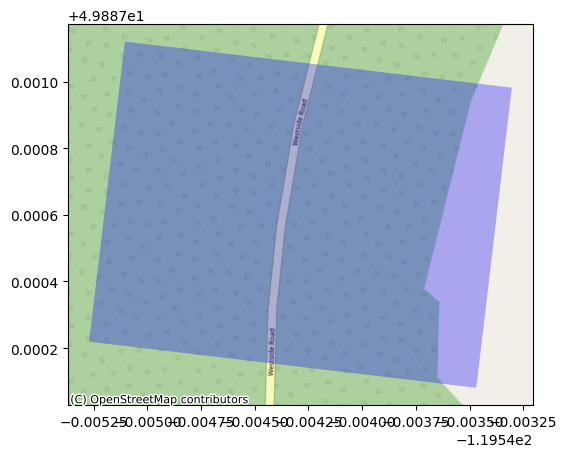

In [ ]:
# Import and visualize the junction file
########################################

import contextily as ctx

path = 'C:/data/gps_sai/bc_gis/outbound_hwy/WKelowna_HNorth_N.shp'

WKelowna_HNorth_N_shp = gpd.read_file(path)

# Set the Coordinate Reference System (CRS) if not already set (WGS84 - EPSG:4326 for lat/long)
WKelowna_HNorth_N_shp.to_crs(epsg=4326, inplace=True)

# Plot the geometries on a basemap
fig, ax = plt.subplots(figsize=(6, 6))

# Plot the roads (your data)
WKelowna_HNorth_N_shp.plot(ax=ax, color='blue', linewidth=1, alpha=0.3)

# Use OpenStreetMap for the basemap
ctx.add_basemap(ax, crs=WKelowna_HNorth_N_shp.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik)

# Show the plot
plt.show()

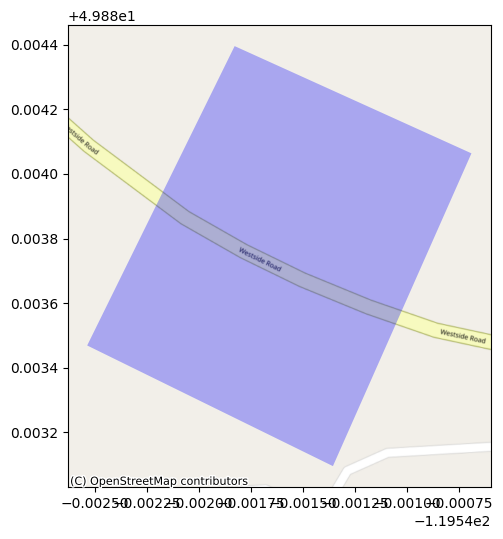

In [ ]:
# Import and visualize the junction file
########################################

import contextily as ctx

path = 'C:/data/gps_sai/bc_gis/outbound_hwy/WKelowna_HNorth_S.shp'

WKelowna_HNorth_S_shp = gpd.read_file(path)

# Set the Coordinate Reference System (CRS) if not already set (WGS84 - EPSG:4326 for lat/long)
WKelowna_HNorth_S_shp.to_crs(epsg=4326, inplace=True)

# Plot the geometries on a basemap
fig, ax = plt.subplots(figsize=(6, 6))

# Plot the roads (your data)
WKelowna_HNorth_S_shp.plot(ax=ax, color='blue', linewidth=1, alpha=0.3)

# Use OpenStreetMap for the basemap
ctx.add_basemap(ax, crs=WKelowna_HNorth_S_shp.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik)

# Show the plot
plt.show()

In [ ]:
# Calculate order among the above two shapefiles
################################################

from cybstr.traject import trip_analysis

counts = trip_analysis.count_trajectory_orders(matched_trips_gdf_west, WKelowna_HNorth_N_shp, WKelowna_HNorth_S_shp)
print("Total trajectories passing both:", counts["total"])
print("Trajectories passing N → S:", counts["A_to_B"])
print("Trajectories passing S → N:", counts["B_to_A"])


Total trajectories passing both: 43
Trajectories passing N → S: 21
Trajectories passing S → N: 22


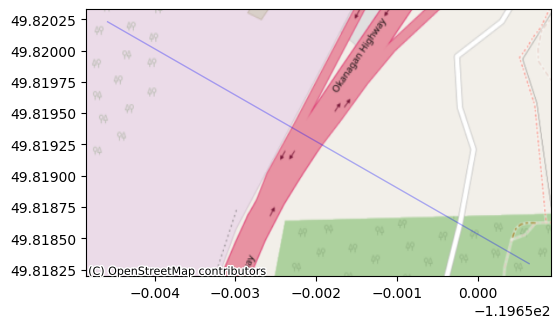

In [ ]:
# Import and visualize the junction file
########################################

import contextily as ctx

path = 'C:/data/gps_sai/bc_gis/outbound_hwy/WKelowna_H97_N.shp'

WKelowna_H97_N_shp = gpd.read_file(path)

# Set the Coordinate Reference System (CRS) if not already set (WGS84 - EPSG:4326 for lat/long)
WKelowna_H97_N_shp.to_crs(epsg=4326, inplace=True)

# Plot the geometries on a basemap
fig, ax = plt.subplots(figsize=(6, 6))

# Plot the roads (your data)
WKelowna_H97_N_shp.plot(ax=ax, color='blue', linewidth=1, alpha=0.3)

# Use OpenStreetMap for the basemap
ctx.add_basemap(ax, crs=WKelowna_H97_N_shp.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik)

# Show the plot
plt.show()

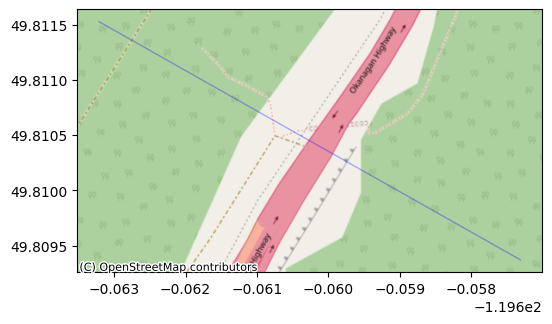

In [ ]:
# Import and visualize the junction file
########################################

import contextily as ctx

path = 'C:/data/gps_sai/bc_gis/outbound_hwy/WKelowna_H97_S.shp'

WKelowna_H97_S_shp = gpd.read_file(path)

# Set the Coordinate Reference System (CRS) if not already set (WGS84 - EPSG:4326 for lat/long)
WKelowna_H97_S_shp.to_crs(epsg=4326, inplace=True)

# Plot the geometries on a basemap
fig, ax = plt.subplots(figsize=(6, 6))

# Plot the roads (your data)
WKelowna_H97_S_shp.plot(ax=ax, color='blue', linewidth=1, alpha=0.3)

# Use OpenStreetMap for the basemap
ctx.add_basemap(ax, crs=WKelowna_H97_S_shp.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik)

# Show the plot
plt.show()

In [ ]:
# Calculate order among the above two shapefiles
################################################

from cybstr.traject import trip_analysis

counts = trip_analysis.count_trajectory_orders(matched_trips_gdf_west, WKelowna_H97_N_shp, WKelowna_H97_S_shp)
print("Total trajectories passing both checkpoints in highway 97 (south of W Kelowna):", counts["total"])
print("Trajectories passing N → S:", counts["A_to_B"])
print("Trajectories passing S → N:", counts["B_to_A"])


Total trajectories passing both checkpoints in highway 97 (south of W Kelowna): 514
Trajectories passing N → S: 201
Trajectories passing S → N: 313


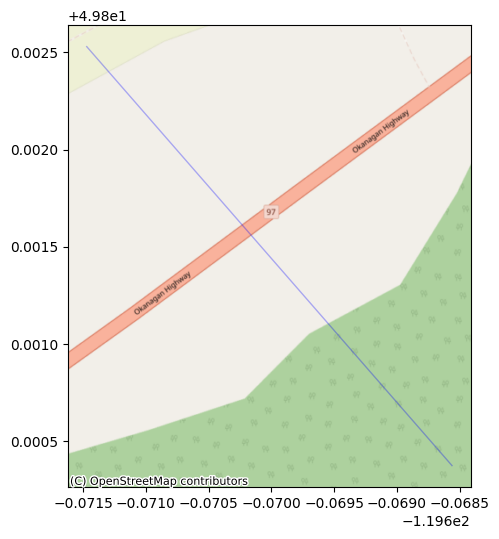

In [ ]:
# Import and visualize the junction file
########################################

import contextily as ctx

path = 'C:/data/gps_sai/bc_gis/outbound_hwy/WKelowna_H97South_N.shp'

WKelowna_H97South_N_shp = gpd.read_file(path)

# Set the Coordinate Reference System (CRS) if not already set (WGS84 - EPSG:4326 for lat/long)
WKelowna_H97South_N_shp.to_crs(epsg=4326, inplace=True)

# Plot the geometries on a basemap
fig, ax = plt.subplots(figsize=(6, 6))

# Plot the roads (your data)
WKelowna_H97South_N_shp.plot(ax=ax, color='blue', linewidth=1, alpha=0.3)

# Use OpenStreetMap for the basemap
ctx.add_basemap(ax, crs=WKelowna_H97South_N_shp.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik)

# Show the plot
plt.show()

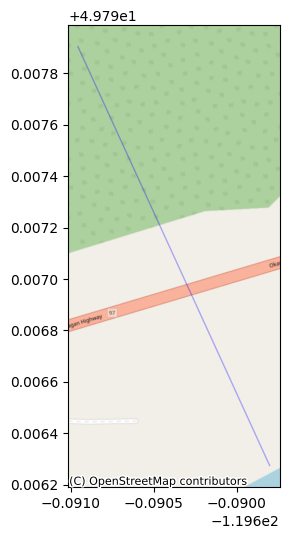

In [ ]:
# Import and visualize the junction file
########################################

import contextily as ctx

path = 'C:/data/gps_sai/bc_gis/outbound_hwy/WKelowna_H97South_S.shp'

WKelowna_H97South_S_shp = gpd.read_file(path)

# Set the Coordinate Reference System (CRS) if not already set (WGS84 - EPSG:4326 for lat/long)
WKelowna_H97South_S_shp.to_crs(epsg=4326, inplace=True)

# Plot the geometries on a basemap
fig, ax = plt.subplots(figsize=(6, 6))

# Plot the roads (your data)
WKelowna_H97South_S_shp.plot(ax=ax, color='blue', linewidth=1, alpha=0.3)

# Use OpenStreetMap for the basemap
ctx.add_basemap(ax, crs=WKelowna_H97South_S_shp.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik)

# Show the plot
plt.show()

In [ ]:
# Calculate order among the above two shapefiles
################################################

from cybstr.traject import trip_analysis

counts = trip_analysis.count_trajectory_orders(matched_trips_gdf_west, WKelowna_H97South_N_shp, WKelowna_H97South_S_shp)
print("Total trajectories passing both checkpoints in southbound highway 97:", counts["total"])
print("Trajectories passing N → S:", counts["A_to_B"])
print("Trajectories passing S → N:", counts["B_to_A"])


Total trajectories passing both checkpoints in southbound highway 97: 477
Trajectories passing N → S: 296
Trajectories passing S → N: 181


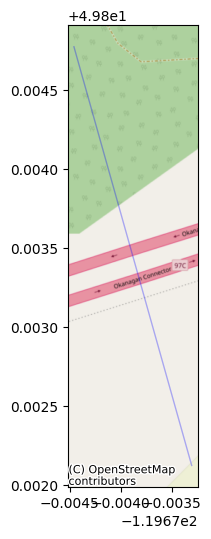

In [ ]:
# Import and visualize the junction file
########################################

import contextily as ctx

path = 'C:/data/gps_sai/bc_gis/outbound_hwy/WKelowna_H97C_E.shp'

WKelowna_H97C_E_shp = gpd.read_file(path)

# Set the Coordinate Reference System (CRS) if not already set (WGS84 - EPSG:4326 for lat/long)
WKelowna_H97C_E_shp.to_crs(epsg=4326, inplace=True)

# Plot the geometries on a basemap
fig, ax = plt.subplots(figsize=(6, 6))

# Plot the roads (your data)
WKelowna_H97C_E_shp.plot(ax=ax, color='blue', linewidth=1, alpha=0.3)

# Use OpenStreetMap for the basemap
ctx.add_basemap(ax, crs=WKelowna_H97C_E_shp.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik)

# Show the plot
plt.show()

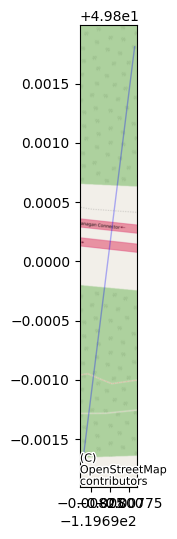

In [ ]:
# Import and visualize the junction file
########################################

import contextily as ctx

path = 'C:/data/gps_sai/bc_gis/outbound_hwy/WKelowna_H97C_W.shp'

WKelowna_H97C_W_shp = gpd.read_file(path)

# Set the Coordinate Reference System (CRS) if not already set (WGS84 - EPSG:4326 for lat/long)
WKelowna_H97C_W_shp.to_crs(epsg=4326, inplace=True)

# Plot the geometries on a basemap
fig, ax = plt.subplots(figsize=(6, 6))

# Plot the roads (your data)
WKelowna_H97C_W_shp.plot(ax=ax, color='blue', linewidth=1, alpha=0.3)

# Use OpenStreetMap for the basemap
ctx.add_basemap(ax, crs=WKelowna_H97C_W_shp.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik)

# Show the plot
plt.show()

In [ ]:
# Calculate order among the above two shapefiles
################################################

from cybstr.traject import trip_analysis

counts = trip_analysis.count_trajectory_orders(matched_trips_gdf_west, WKelowna_H97C_E_shp, WKelowna_H97C_W_shp)
print("Total trajectories passing both checkpoints in highway 97C:", counts["total"])
print("Trajectories passing E → W:", counts["A_to_B"])
print("Trajectories passing W → E:", counts["B_to_A"])


Total trajectories passing both checkpoints in highway 97C: 21
Trajectories passing E → W: 4
Trajectories passing W → E: 17


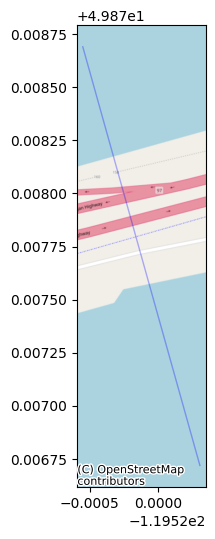

In [ ]:
# Import and visualize the junction file
########################################

import contextily as ctx

path = 'C:/data/gps_sai/bc_gis/outbound_hwy/WKelowna_H97_Downtown_W.shp'

WKelowna_H97_Downtown_W_shp = gpd.read_file(path)

# Set the Coordinate Reference System (CRS) if not already set (WGS84 - EPSG:4326 for lat/long)
WKelowna_H97_Downtown_W_shp.to_crs(epsg=4326, inplace=True)

# Plot the geometries on a basemap
fig, ax = plt.subplots(figsize=(6, 6))

# Plot the roads (your data)
WKelowna_H97_Downtown_W_shp.plot(ax=ax, color='blue', linewidth=1, alpha=0.3)

# Use OpenStreetMap for the basemap
ctx.add_basemap(ax, crs=WKelowna_H97_Downtown_W_shp.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik)

# Show the plot
plt.show()

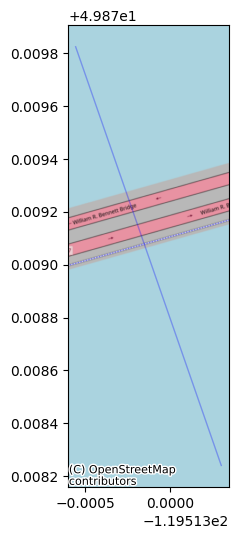

In [ ]:
# Import and visualize the junction file
########################################

import contextily as ctx

path = 'C:/data/gps_sai/bc_gis/outbound_hwy/WKelowna_H97_Downtown_E.shp'

WKelowna_H97_Downtown_E_shp = gpd.read_file(path)

# Set the Coordinate Reference System (CRS) if not already set (WGS84 - EPSG:4326 for lat/long)
WKelowna_H97_Downtown_E_shp.to_crs(epsg=4326, inplace=True)

# Plot the geometries on a basemap
fig, ax = plt.subplots(figsize=(6, 6))

# Plot the roads (your data)
WKelowna_H97_Downtown_E_shp.plot(ax=ax, color='blue', linewidth=1, alpha=0.3)

# Use OpenStreetMap for the basemap
ctx.add_basemap(ax, crs=WKelowna_H97_Downtown_E_shp.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik)

# Show the plot
plt.show()

In [ ]:
# Calculate order among the above two shapefiles
################################################

from cybstr.traject import trip_analysis

counts = trip_analysis.count_trajectory_orders(matched_trips_gdf_west, WKelowna_H97_Downtown_E_shp, WKelowna_H97_Downtown_W_shp)
print("Total trajectories passing both checkpoints in highway 97 leading to Kelowna Downtown:", counts["total"])
print("Trajectories passing E → W:", counts["A_to_B"])
print("Trajectories passing W → E:", counts["B_to_A"])


Total trajectories passing both checkpoints in highway 97 leading to Kelowna Downtown: 27
Trajectories passing E → W: 13
Trajectories passing W → E: 14


In [ ]:
matched_trips_gdf_west

,day,gps_id,trip_id,geometry,time_pos_dict
0,2023-08-01,003b4c3a-8bc5-39e2-a32a-dee461460462,8,"LINESTRING (-119.66147 49.80885, -119.66114 49...",{2023-08-01 18:37:23: POINT (-119.661473690418...
1,2023-08-01,004620ae-98e2-3513-bffb-c6835f4131fd,12,"LINESTRING (-119.66873 49.83240, -119.66917 49...",{2023-08-01 11:32:32: POINT (-119.668734190944...
2,2023-08-01,004620ae-98e2-3513-bffb-c6835f4131fd,13,"LINESTRING (-119.66845 49.83265, -119.66873 49...",{2023-08-01 15:31:37: POINT (-119.668453317465...
3,2023-08-01,004620ae-98e2-3513-bffb-c6835f4131fd,14,"LINESTRING (-119.66870 49.84539, -119.66820 49...",{2023-08-01 18:58:01: POINT (-119.6686978 49.8...
4,2023-08-01,005a1d04-c1c0-3ec6-a0e3-ced44621ffb4,18,"LINESTRING (-119.62930 49.82606, -119.62875 49...",{2023-08-01 20:09:40: POINT (-119.6292979 49.8...
...,...,...,...,...,...
4716,2023-08-01,ffe7819e-57ff-3af1-b3fb-29fac2a7a23f,18504,"LINESTRING (-119.58329 49.86271, -119.58402 49...",{2023-08-01 14:09:45: POINT (-119.583289898792...
4717,2023-08-01,ffe94a10-c86d-374a-a72b-4bb11910e4a6,18511,"LINESTRING (-119.58317 49.86264, -119.58385 49...",{2023-08-01 16:04:42: POINT (-119.583168367830...
4718,2023-08-01,ffecb3f6-1123-34ca-810f-76486ae5c5c8,18516,"LINESTRING (-119.56368 49.86283, -119.56454 49...",{2023-08-01 21:38:27: POINT (-119.5636836 49.8...
4719,2023-08-01,fffaa8d2-af8c-3ee6-b17d-0dd5ab63b5c1,18521,"LINESTRING (-119.58317 49.86264, -119.58385 49...",{2023-08-01 16:13:08: POINT (-119.583168367830...


<H3>Part J3.4: Testing the direction</H3>

In [ ]:
# Print the entries for a particular trip: Trajectory
#####################################################

subtrip_gdf = WKelowna_H97_Kelowna_intersecting_trajs[
    (WKelowna_H97_Kelowna_intersecting_trajs['gps_id'] == '62d3c896-1beb-3d60-aaf2-786a5ec72c9b') &
    (WKelowna_H97_Kelowna_intersecting_trajs['trip_id'] == 7115)
]

display(subtrip_gdf)

,day,gps_id,trip_id,geometry,time_pos_dict,index_right,BUFF_DIST,AnalysisAr,start_point,end_point,nearest_road,road_start,road_end,direction,bearing_traj
1799,2023-08-01,62d3c896-1beb-3d60-aaf2-786a5ec72c9b,7115,"LINESTRING (-119.61035 49.86734, -119.61078 49...",{2023-08-01 21:21:04: POINT (-119.6103542 49.8...,0,100.0,0.525622,POINT (-119.61035 49.86734),POINT (-119.51530 49.87874),0,POINT (-119.529596594231 49.8853910017949),POINT (-119.503418234245 49.8809389603255),Forward,13.142823


In [ ]:
# Print the entries for a particular trip: GPS
##############################################

subtrip_gdf = matched_trips_gdf_west[
    (matched_trips_gdf_west['gps_id'] == 'd6699b58-da6a-3b15-891f-fbde46b867e8') &
    (matched_trips_gdf_west['trip_id'] == 15556)
]

display(subtrip_gdf)

,day,gps_id,trip_id,geometry,time_pos_dict
3932,2023-08-01,d6699b58-da6a-3b15-891f-fbde46b867e8,15556,"LINESTRING (-119.60543 49.85413, -119.60596 49...",{2023-08-01 19:38:08: POINT (-119.605427122779...


In [ ]:
subtrip_gdf = matched_trips_gdf_west[
    (matched_trips_gdf_west['gps_id'] == 'd6699b58-da6a-3b15-891f-fbde46b867e8') &
    (matched_trips_gdf_west['trip_id'] == 15556)
]

display(subtrip_gdf['geometry'])

3932    LINESTRING (-119.60543 49.85413, -119.60596 49...
Name: geometry, dtype: geometry

In [ ]:
# Print the entries for a particular trip: GPS
##############################################

subtrip_gdf = kelowna_gps_01Aug_west[
    (kelowna_gps_01Aug_west['registrationID'] == 'd6699b58-da6a-3b15-891f-fbde46b867e8') &
    (kelowna_gps_01Aug_west['trip_id'] == 15556)
]

display(subtrip_gdf)

,DateTime,registrationID,latitude,longitude,recordCount,geometry,index_right,Id,time_diff,trip_id


In [ ]:
# Initialize a map centered around the first point
map_center = [49.862500, -119.583300]
m = folium.Map(location=map_center, zoom_start=13)

# Add points to the map
for index, row in subtrip_gdf.iterrows():
    folium.Marker([row['latitude'], row['longitude']]).add_to(m)

# Show the map
m

In [ ]:
# Get unique latitudes and longitudes
#####################################

unique_latitudes = subtrip_gdf[['latitude']].drop_duplicates()
unique_longitudes = subtrip_gdf[['longitude']].drop_duplicates()

# Print the unique latitudes and longitudes
print("Unique Latitudes:")
print(unique_latitudes)

print("\nUnique Longitudes:")
print(unique_longitudes)

Unique Latitudes:
          latitude
2061946  49.862500
2634977  49.862499

Unique Longitudes:
          longitude
2061946 -119.583300
2634977 -119.583297


In [ ]:
# Print all entries from the main dataframe (for whole of Kelowna)
##################################################################

subtrip_gdf = kelowna_gps_01Aug[
    (kelowna_gps_01Aug['registrationID'] == 'd6699b58-da6a-3b15-891f-fbde46b867e8')
]

display(subtrip_gdf)

,DateTime,registrationID,latitude,longitude,recordCount,geometry
1541168,2023-08-01 16:04:04,d6699b58-da6a-3b15-891f-fbde46b867e8,49.764700,-119.744600,6,POINT (-119.74460 49.76470)
1541173,2023-08-01 16:04:41,d6699b58-da6a-3b15-891f-fbde46b867e8,49.764700,-119.744600,2,POINT (-119.74460 49.76470)
1541182,2023-08-01 16:05:28,d6699b58-da6a-3b15-891f-fbde46b867e8,49.764700,-119.744600,5,POINT (-119.74460 49.76470)
1541189,2023-08-01 16:06:15,d6699b58-da6a-3b15-891f-fbde46b867e8,49.764700,-119.744600,1,POINT (-119.74460 49.76470)
1541205,2023-08-01 16:07:39,d6699b58-da6a-3b15-891f-fbde46b867e8,49.764700,-119.744600,3,POINT (-119.74460 49.76470)
1541211,2023-08-01 16:08:29,d6699b58-da6a-3b15-891f-fbde46b867e8,49.764700,-119.744600,2,POINT (-119.74460 49.76470)
1541233,2023-08-01 16:10:29,d6699b58-da6a-3b15-891f-fbde46b867e8,49.764700,-119.744600,2,POINT (-119.74460 49.76470)
1541253,2023-08-01 16:12:27,d6699b58-da6a-3b15-891f-fbde46b867e8,49.764701,-119.744598,3,POINT (-119.74460 49.76470)
1541257,2023-08-01 16:13:02,d6699b58-da6a-3b15-891f-fbde46b867e8,49.764700,-119.744600,6,POINT (-119.74460 49.76470)
1541264,2023-08-01 16:13:38,d6699b58-da6a-3b15-891f-fbde46b867e8,49.764700,-119.744600,3,POINT (-119.74460 49.76470)


In [ ]:
# Get all latitudes and longitudes as lists
latitudes_list = subtrip_gdf['latitude'].tolist()
longitudes_list = subtrip_gdf['longitude'].tolist()

# Print the lists
print("Latitudes:", latitudes_list)
print("Longitudes:", longitudes_list)


Latitudes: [49.8625, 49.8625, 49.8625, 49.8625, 49.8625, 49.8625, 49.8625, 49.8625, 49.8625, 49.8625, 49.8625, 49.8625, 49.8625, 49.8625, 49.8625, 49.8625, 49.8625, 49.8625, 49.8625, 49.8625, 49.8625, 49.8625, 49.8625, 49.8625, 49.8625, 49.8625, 49.8625, 49.8625, 49.8625, 49.8625, 49.8625, 49.8625, 49.8625, 49.8625, 49.8625, 49.8625, 49.8625, 49.8625, 49.8625, 49.8625, 49.8625, 49.8625, 49.8625, 49.8625, 49.8625, 49.8625, 49.8625, 49.8625, 49.8625, 49.8625, 49.8625, 49.8625, 49.8625, 49.8625, 49.8625, 49.8625, 49.8625, 49.8625, 49.8625, 49.8625, 49.8625, 49.8625, 49.8625, 49.8625, 49.8625, 49.8625, 49.8625, 49.8625, 49.8625, 49.8625, 49.8625, 49.8625, 49.8625, 49.8625, 49.862499, 49.8625, 49.8625, 49.8625, 49.8625, 49.8625, 49.8625, 49.8625, 49.8625, 49.8625, 49.8625, 49.8625, 49.8625, 49.8625, 49.8625, 49.8625, 49.8625, 49.8625, 49.8625, 49.8625, 49.8625, 49.8625, 49.8625, 49.8625, 49.8625, 49.8625, 49.8625, 49.8625, 49.8625, 49.8625, 49.8625, 49.8625, 49.8625, 49.8625, 49.8625, 49.86

In [ ]:
# Testing: A function to select 5 GPS IDs for each direction and plot them
##########################################################################

from cybstr.genera import plotmap
import random

def generate_random_maps(gps_df, trajs_df, num_samples=5):
    """
    Randomly selects 5 GPS IDs with direction 'Forward' and 5 with direction 'Reverse',
    then generates and saves maps for each using `plot_trajectory_on_folium`.

    Parameters:
    ----------
    gps_df : GeoDataFrame
        GPS points dataframe containing latitude, longitude, and trip information.
    trajs_df : GeoDataFrame
        Trajectories dataframe containing trip_id, geometry, and direction.
    num_samples : int, optional
        Number of GPS IDs to select per direction (default is 5).

    Returns:
    -------
    list
        List of saved map filenames.
    """

    saved_maps = []

    # Select unique GPS IDs for each direction
    forward_gps_ids = trajs_df[trajs_df["direction"] == "Forward"]["gps_id"].unique()
    reverse_gps_ids = trajs_df[trajs_df["direction"] == "Reverse"]["gps_id"].unique()

    # Randomly sample GPS IDs (ensuring we don't exceed available IDs)
    selected_forward_ids = random.sample(list(forward_gps_ids), min(num_samples, len(forward_gps_ids)))
    selected_reverse_ids = random.sample(list(reverse_gps_ids), min(num_samples, len(reverse_gps_ids)))

    # Generate maps for selected GPS IDs
    for gps_id in selected_forward_ids + selected_reverse_ids:
        # Determine the direction for this GPS ID
        direction = trajs_df.loc[trajs_df["gps_id"] == gps_id, "direction"].iloc[0]

        # Get available trips for this GPS ID
        trips = trajs_df[trajs_df["gps_id"] == gps_id]["trip_id"].unique()

        if len(trips) == 0:
            continue  # Skip if no trips found

        # Select a random trip for this GPS ID
        trip_no = random.choice(trips)

        # Call the function to generate the map
        map_filename = plot_trajectory_on_folium(gps_df, trajs_df, gps_id, trip_no)

        # Rename the file to include the direction
        new_map_filename = map_filename.replace(".html", f"_{direction}.html")
        os.rename(map_filename, new_map_filename)

        saved_maps.append(new_map_filename)

    return saved_maps



In [ ]:
# Testing the above function
############################

saved_maps = generate_random_maps(kelowna_gps_01Aug_west, WKelowna_H97_Kelowna_intersecting_trajs)
print("Maps saved:", saved_maps)


Map saved as 9399f0dc-8318-3901-bd7c-c10fb093c02f_10585_map.html
Map saved as 6a750f3f-7308-30a7-bc84-000b21210e1e_7679_map.html
Map saved as 76480dc7-4367-3d88-b6b3-54d177777453_8470_map.html
Map saved as d6699b58-da6a-3b15-891f-fbde46b867e8_15556_map.html
Map saved as f75ca62b-a309-3ced-96c9-f0aab34d6351_17947_map.html
Map saved as 69254491-1112-3abf-bec2-09da1e3319d9_7591_map.html
Map saved as 332a6b31-b87e-309b-aed1-e69b16e336b5_3580_map.html
Map saved as 1522d677-a913-3281-9d66-ea9a558949a3_1498_map.html
Map saved as 8ca96e05-b337-380b-931c-9e950655c6db_10064_map.html
Map saved as 4026bccd-cd72-3689-a273-ead4ad8d5f42_4593_map.html
Maps saved: ['9399f0dc-8318-3901-bd7c-c10fb093c02f_10585_map_Forward.html', '6a750f3f-7308-30a7-bc84-000b21210e1e_7679_map_Forward.html', '76480dc7-4367-3d88-b6b3-54d177777453_8470_map_Forward.html', 'd6699b58-da6a-3b15-891f-fbde46b867e8_15556_map_Forward.html', 'f75ca62b-a309-3ced-96c9-f0aab34d6351_17947_map_Forward.html', '69254491-1112-3abf-bec2-09da1